In [2]:
import pandas as pd
import numpy as np
from string import ascii_letters
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Прочитаем данные

In [10]:
df = pd.read_csv('prepared_data/dataset.csv', sep=',', encoding="utf-8")
df.head()

,лицензия,дата,net_assets,ROA,liquid,ibl,stocks,bond,oth_cap,sunk_retail_credit,...,micex_return,net_foreign_assets_diff,net_gov_debt_diff,other_fin_debt_diff,retail_debt_SA_DETREND_diff,stocks_capital_diff,i_retail_spread_diff,usd_rub_return,miacr_diff,default
0,0.0,2010-02-01,423017.0,27.0,112770.0,60000.0,0.0,0.0,0.0,0.0,...,0.000000,-156425.0,1595305.0,47521.0,33587.30532,214757.0,0.0,0.008065,-0.830116,0.0
1,0.0,2010-03-01,498411.0,75.0,172628.0,90000.0,0.0,0.0,0.0,0.0,...,-0.057148,225429.0,-265831.0,-34392.0,22186.02349,59909.0,-0.1,0.010699,-0.172562,0.0
2,0.0,2010-04-01,571220.0,54.0,211860.0,90000.0,0.0,0.0,0.0,997.0,...,0.043424,-128438.0,430871.0,-21876.0,-14983.52885,4293.0,0.1,-0.019848,-0.296650,0.0
3,0.0,2010-05-01,523027.0,41.0,159970.0,90000.0,0.0,0.0,0.0,481.0,...,0.048447,-223667.0,92737.0,-1075.0,-19523.94108,64243.0,-0.1,-0.012387,-0.255000,0.0
4,0.0,2010-06-01,473713.0,31.0,131782.0,135000.0,0.0,0.0,0.0,485.0,...,-0.105536,251702.0,-134963.0,81.0,-20743.43746,36008.0,0.1,0.042533,-0.533087,0.0


In [12]:
df = df[df['net_assets'] != 0]

df.drop_duplicates(inplace = True)

# Feature Engineering

## _1. Фичи для классификации_

In [13]:
# 1. Прибыльность
# df['ROA']
# df['ROE']
# df['NI_growth'] - может быть с этим что-то сделать

# 2. Достаточность капитала
df['cap_net_assets'] = df['capital'] / df['net_assets']*100

# 3. Ликвидность
# df['N3'] 
# df['N2'] 
# df['N1'] 
# df['retail_deposit_fr'] - отток средств из банка

# 4. Размер банка
df['log_net_assets'] = np.log(df['net_assets'] + 1)

# 5. Кредитный риск
df['sunk_credit_portf_perc'] = df['sunk_credit_portf'] / (df['credit_portf'] + 1)*100
df['zalog_sunk_credit'] = df['zalog_credit_perc'] / (df['sunk_credit_portf'] + 1)*100 # обеспеченность просрочки залогом ??

# 6. Показатели фальсификации отчётности

## фальсификация
df['reserv_sunk_portf'] = (df['reserv_credit_perc']/100) - df['sunk_credit_portf_perc']*100
df['oth_cap_net_assets'] = df['oth_cap'] / df['net_assets']*100
df['security_net_assets'] = df['security_tot'] / df['net_assets']*100
# df[d_security_net_assets] - ПОСЧИТАЙ!
df['liquid_net_assets'] = df['liquid'] / df['net_assets']*100

## высокая оборачиваемость
# df['foreign_na_fr']

## низкая маржинальность бизнеса
df['retail_dep_org_credit'] = (df['retail_deposit'] / df['net_assets'])*(df['organization_credit'] / df['net_assets'])

In [ ]:
# Степень монопольной власти отдельной фирмы
unique_license = df['лицензия'].unique()
unique_dates = df['дата'].unique()

market_share = pd.DataFrame(np.zeros([len(unique_license)*len(unique_dates), 3]))
market_share.columns = ['лицензия', 'дата', 'credit_market_share']

for i in range(df.shape[0]):
    a = float(df.iloc[i, 13]) / (float(np.sum(df[df['дата'] == df.iloc[i, 1]]['credit_portf'])) + 1)
    market_share.iloc[i, 0] = df.iloc[i, 0].astype(int)
    market_share.iloc[i, 1] = df.iloc[i, 1]
    market_share.iloc[i, 2] = a

In [47]:
market_share['лицензия'] = market_share['лицензия'].astype(float).astype(int)
market_share['дата'] = pd.to_datetime(market_share['дата'])

In [131]:
market_share.head()

,лицензия,дата,credit_market_share
0,0,2010-02-01,0.000015
1,0,2010-03-01,0.000015
2,0,2010-04-01,0.002000
3,0,2010-05-01,0.000015
4,0,2010-06-01,0.000012


In [49]:
# Монополизация отрасли
df['HHI_credit'] = 0
hhi = []
for dat in unique_dates:
    HHI = np.sum(np.array(df[df['дата'] == dat].iloc[:, 13])**2)/(np.sum(np.array(df[df['дата'] == '2012-01-01'].iloc[:, 13]))**2)*100
    hhi.extend([HHI])
df_hhi = pd.DataFrame(hhi, unique_dates)
df_hhi.columns = ['HHI_credit']

## заменю выбросы
df_hhi.iloc[2,:] = 6.5
df_hhi.iloc[10,:] = 8.0

In [50]:
df_hhi['HHI_credit'] = np.append(np.array([0]), np.diff(df_hhi['HHI_credit']))
hhi.columns = ['дата', 'HHI_credit_diff']

In [51]:
df['дата'] = pd.to_datetime(df['дата'])

In [52]:
df = df.set_index(['лицензия', 'дата']).join(market_share.set_index(['лицензия','дата']), how = 'left')

In [53]:
df = df.join(hhi.set_index(['дата']), how = 'left')

## _2. Фичи для кластеризации / сегментации_

In [54]:
# 1. Структура активов
df['bond_net_assets'] = df['bond'] / df['net_assets']*100
df['org_credit_net_assets'] = df['organization_credit'] / df['net_assets']*100

In [55]:
df.columns

Index(['net_assets', 'ROA', 'liquid', 'ibl', 'stocks', 'bond', 'oth_cap',
       'sunk_retail_credit', 'NI', 'organization_credit',
       'sunk_organization_credit', 'credit_portf', 'sunk_credit_portf',
       'organization_deposit', 'retail_deposit', 'security_tot', 'ROE',
       'retail_credit', 'reserv_credit_perc', 'zalog_credit_perc',
       'foreign_na_fr', 'retail_deposit_fr', 'N3', 'N2', 'N1', 'capital',
       'msk_spb', 'M2', 'M2_SA', 'INF_SA', 'NX', 'NX_log', 'Nx_growth',
       'usd_rub', 'usd_rub_std', 'micex', 'micex_std', 'miacr', 'miacr_std',
       'miacr_amount', 'net_foreign_assets', 'net_gov_debt', 'other_fin_debt',
       'retail_debt', 'stocks_capital', 'i_retail_credit', 'i_retail_debit',
       'i_retail_spread', 'default', 'cap_net_assets', 'log_net_assets',
       'sunk_credit_portf_perc', 'zalog_sunk_credit', 'reserv_sunk_portf',
       'oth_cap_net_assets', 'security_net_assets', 'liquid_net_assets',
       'retail_dep_org_credit', 'HHI_credit', 'credit_mar

In [56]:
df_no_macro = df[['default',            # тагрет
               'ROA', 'ROE',            # прибыльность
               'cap_net_assets',        # достаточность капитала
               'N3', 'N2', 'N1', 'retail_deposit_fr',   # ликвидность
               'log_net_assets',        # размер банка
               'credit_market_share',   # монопольная власть
               'sunk_credit_portf_perc', 'zalog_sunk_credit',   # качество кредит портфеля
               'reserv_sunk_portf', 'oth_cap_net_assets',  'security_net_assets', 'liquid_net_assets',  # фальсификация 1
               'foreign_na_fr',         # фальсификация 2
               'retail_dep_org_credit', # фальсификация 3
               'bond_net_assets', 'org_credit_net_assets',  # структура активов
               'HHI_credit_diff',       # монополизация отрасли
               'msk_spb']]              # регистрация в Мск или Спб

In [57]:
df_no_macro.head(2)

default   ROA    ROE  cap_net_assets     N3      N2  \
лицензия дата                                                              
0        2010-02-01      0.0  27.0   54.0       53.889560  92.27  9915.0   
         2010-03-01      0.0  75.0  150.0       45.856131  92.27  9915.0   

                         N1  retail_deposit_fr  log_net_assets  \
лицензия дата                                                    
0        2010-02-01  2058.0           482234.0       12.955170   
         2010-03-01  2058.0           482234.0       13.119182   

                     credit_market_share   ...     reserv_sunk_portf  \
лицензия дата                              ...                         
0        2010-02-01             0.000015   ...                 10.94   
         2010-03-01             0.000015   ...                 10.94   

                     oth_cap_net_assets  security_net_assets  \
лицензия дата                                                  
0        2010-02-01                 0.0                  0.0   
         2010-03-01                 0.0                  0.0   

                     liquid_net_assets  foreign_na_fr  retail_dep_org_credit  \
лицензия дата                                                                  
0        2010-02-01          26.658503         2075.0               0.076709   
         2010-03-01          34.635672         2075.0               0.075877   

                     bond_net_assets  org_credit_net_assets  HHI_credit_diff  \
лицензия дата                                                                  
0        2010-02-01              0.0              53.189352         0.000000   
         2010-03-01              0.0              45.143466        -0.034277   

                     msk_spb  
лицензия дата                 
0        2010-02-01      0.0  
         2010-03-01      0.0  

[2 rows x 22 columns]

In [58]:
df_no_macro.to_csv('dataset_4.csv',sep=',',header=True,index=True)

# Добавим 1 в default для санируемых банков

In [532]:
# http://www.bankodrom.ru/spisok-saniruemyh-bankov-v-rossii/

licence_sanation = [23, 128, 3176, 323, 2827, 2748, 312, 1557, 3252, 2763, 3360, 1751, 2270, 2534, 3251, 2312, 2888, 1317,\
          558, 554, 1132, 2304, 1581, 3279, 2275]
dates_sanation = pd.to_datetime(['2015-07-01', '2014-08-01', '2015-12-01', '2017-09-01', '2017-09-01', '2012-07-01',\
                      '2015-08-01', '2015-08-01', '2015-08-01', '2015-08-01', '2015-12-01', '2014-05-01',\
                      '2018-03-01', '2015-08-01', '2017-12-01', '2008-10-01', '2017-09-01', '2011-06-01',\
                      '2015-10-01', '2013-12-01', '2015-08-01', '2015-03-01', '2014-05-01', '2014-12-01',\
                      '2015-11-01'])

Проверка на ошибки ввода

In [533]:
len(licence_sanation) == len(dates_sanation)

True

In [547]:
df_no_macro = pd.read_csv('dataset_4.csv',sep=',', header = 0,  encoding="cp1251")

In [548]:
df_no_macro.head(2)

,лицензия,дата,default,ROA,ROE,cap_net_assets,N3,N2,N1,retail_deposit_fr,...,reserv_sunk_portf,oth_cap_net_assets,security_net_assets,liquid_net_assets,foreign_na_fr,retail_dep_org_credit,bond_net_assets,org_credit_net_assets,HHI_credit_diff,msk_spb
0,0,2010-02-01,0.0,27.0,54.0,53.889560,92.27,9915.0,2058.0,482234.0,...,10.94,0.0,0.0,26.658503,2075.0,0.076709,0.0,53.189352,0.000000,0.0
1,0,2010-03-01,0.0,75.0,150.0,45.856131,92.27,9915.0,2058.0,482234.0,...,10.94,0.0,0.0,34.635672,2075.0,0.075877,0.0,45.143466,-0.034277,0.0


In [549]:
df_no_macro['дата'] = pd.to_datetime(df_no_macro['дата'])
df_no_macro['лицензия'] = df_no_macro['лицензия'].astype(int)

In [550]:
for i in range(len(licence_sanation) - 1):
    a = df_no_macro[df_no_macro['лицензия'] == licence_sanation[i]]
    b = a[a['дата'] == dates_sanation[i]]
    c = b.index 
    df_no_macro.iloc[c, 2] = 1

#  Переведем банковские показатели на момент t-1

Показатели банков на НАЧАЛО 't-1'-ого месяца, то есть за 't-2'-ой месяц

In [551]:
default = df_no_macro['default']

In [552]:
d = default[1:]
d = d.append(d[0:1], ignore_index = True)
df_no_macro['default'] = d

# Специфицирую переменную default

Сделать так, чтобы 1 в default стояла за 1, 2, 3 месяца до дефолта. За 1 месяц - уже проставлена

In [555]:
delete_index = np.array([])
for i in df_no_macro[df_no_macro['default'] == 1].index:
    df_no_macro.iloc[i-1, 2] = 1
    df_no_macro.iloc[i-2, 2] = 1
    a = df_no_macro[df_no_macro['лицензия'] == df_no_macro.iloc[i, 0]]
    b = a[a.index > i]
    delete_index = np.append(delete_index, np.array(b.index))

In [558]:
df_no_macro.drop(delete_index, axis = 0, inplace = True)

In [559]:
df_no_macro.shape

(71712, 24)

In [560]:
df_no_macro[df_no_macro['default'] == 1]['default'].count()

1181

# Добавим макро-показатели в момент t-1, приведённые к I(0) виду

Макро показатели за ВЕСЬ 't-1'-ый месяц

In [119]:
macro = pd.read_csv('save_ok4.csv',sep=';', header = 0)
macro.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [120]:
macro.head(4)

,Date,INF_SA,NX_growth,micex_std,miacr_std,miacr_amount,usd_rub_std_diff,micex_return,net_foreign_assets_diff,net_gov_debt_diff,other_fin_debt_diff,retail_debt_SA_DETREND_diff,stocks_capital_diff,i_retail_spread_diff,usd_rub_return,miacr_diff
0,01.01.2010,0.020000,0,32.00000,1.181512,2643995,1.081969,0.000000,-156425,1595305,47521,33587.30532,214757,0.0,0.008065,-0.830116
1,01.02.2010,0.020000,2728,29.75618,0.724981,2643995,1.081969,0.000000,-156425,1595305,47521,33587.30532,214757,0.0,0.008065,-0.830116
2,01.03.2010,0.027475,-980,40.07545,0.330918,2643995,-0.527030,-0.057148,225429,-265831,-34392,22186.02349,59909,-0.1,0.010699,-0.172562
3,01.04.2010,0.024986,-299,23.77384,0.359785,2643995,0.345271,0.043424,-128438,430871,-21876,-14983.52885,4293,0.1,-0.019848,-0.296650


In [121]:
# создадаи те же даты
years = [str(item) for item in range(2010,2018)]
months = [str(item) for item in range(1,13)]
months2 = [ ]
for item in months:
    if len(item)==1:
        item = '0'+item
    months2.append(item)
dats = [ ]
for item in years:
    for jtem in months2:
        dats.append(item + '-' + jtem + '-01')

dats.append('2018-01-01')
dats = pd.to_datetime(dats)
macro['Date'] = dats

In [122]:
columns_ok = ['дата', 'INF_SA', 'NX_growth', 'micex_std', 'miacr_std', 'miacr_amount',
        'usd_rub_std_diff', 'micex_return', 'net_foreign_assets_diff',
        'net_gov_debt_diff', 'other_fin_debt_diff',
        'retail_debt_SA_DETREND_diff', 'stocks_capital_diff',
        'i_retail_spread_diff', 'usd_rub_return', 'miacr_diff']
macro.columns = columns_ok

In [123]:
df_macro = df_no_macro.set_index(['лицензия', 'дата']).join(macro.set_index(['дата']), how = 'left')

NameError: name 'df_no_macro' is not defined

In [566]:
df_macro.head(5)

default   ROA    ROE  cap_net_assets     N3      N2  \
лицензия дата                                                              
0        2010-02-01      0.0  27.0   54.0       53.889560  92.27  9915.0   
         2010-03-01      0.0  75.0  150.0       45.856131  92.27  9915.0   
         2010-04-01      0.0  54.0  114.0       40.013480  92.27  9915.0   
         2010-05-01      0.0  41.0   89.0       43.703671  92.27  9915.0   
         2010-06-01      0.0  31.0   68.0       48.108454  92.27  9915.0   

                         N1  retail_deposit_fr  log_net_assets  \
лицензия дата                                                    
0        2010-02-01  2058.0           482234.0       12.955170   
         2010-03-01  2058.0           482234.0       13.119182   
         2010-04-01  2058.0           482234.0       13.255531   
         2010-05-01  2058.0           482234.0       13.167390   
         2010-06-01  2058.0           482234.0       13.068359   

                     credit_market_share     ...      usd_rub_std_diff  \
лицензия дата                                ...                         
0        2010-02-01             0.000015     ...              1.081969   
         2010-03-01             0.000015     ...             -0.527030   
         2010-04-01             0.002000     ...              0.345271   
         2010-05-01             0.000015     ...             -0.334974   
         2010-06-01             0.000012     ...              2.929403   

                     micex_return  net_foreign_assets_diff  net_gov_debt_diff  \
лицензия дата                                                                   
0        2010-02-01      0.000000                  -156425            1595305   
         2010-03-01     -0.057148                   225429            -265831   
         2010-04-01      0.043424                  -128438             430871   
         2010-05-01      0.048447                  -223667              92737   
         2010-06-01     -0.105536                   251702            -134963   

                     other_fin_debt_diff  retail_debt_SA_DETREND_diff  \
лицензия дата                                                           
0        2010-02-01                47521                  33587.30532   
         2010-03-01               -34392                  22186.02349   
         2010-04-01               -21876                 -14983.52885   
         2010-05-01                -1075                 -19523.94108   
         2010-06-01                   81                 -20743.43746   

                     stocks_capital_diff  i_retail_spread_diff  \
лицензия дата                                                    
0        2010-02-01               214757                   0.0   
         2010-03-01                59909                  -0.1   
         2010-04-01                 4293                   0.1   
         2010-05-01                64243                  -0.1   
         2010-06-01                36008                   0.1   

                     usd_rub_return  miacr_diff  
лицензия дата                                    
0        2010-02-01        0.008065   -0.830116  
         2010-03-01        0.010699   -0.172562  
         2010-04-01       -0.019848   -0.296650  
         2010-05-01       -0.012387   -0.255000  
         2010-06-01        0.042533   -0.533087  

[5 rows x 37 columns]

In [567]:
df_macro.to_csv('dataset_ok2.csv',sep=',',header=True,index=True)

# Удаление выбросов

In [124]:
df_macro = pd.read_csv('dataset_ok2.csv',sep=',', header = 0,  encoding="cp1251")
df_macro = df_macro.set_index(['лицензия', 'дата'])
df_macro.astype(float)

default      ROA       ROE  cap_net_assets        N3  \
лицензия дата                                                               
0        2010-02-01      0.0     27.0      54.0       53.889560     92.27   
         2010-03-01      0.0     75.0     150.0       45.856131     92.27   
         2010-04-01      0.0     54.0     114.0       40.013480     92.27   
         2010-05-01      0.0     41.0      89.0       43.703671     92.27   
         2010-06-01      0.0     31.0      68.0       48.108454     92.27   
         2010-07-01      0.0     30.0      68.0       32.077599     92.27   
         2010-08-01      0.0     31.0      75.0       29.191907     92.27   
         2010-09-01      0.0     31.0      77.0       31.269068     92.27   
         2010-10-01      0.0     27.0      71.0       23.791749     92.27   
         2010-11-01      0.0     28.0      79.0       24.750229     92.27   
         2010-12-01      0.0     25.0      72.0       23.095913     92.27   
         2011-01-01      0.0     25.0      76.0       17.924590     92.27   
         2011-02-01      0.0     16.0      87.0       18.153761     92.27   
         2011-03-01      0.0     17.0      98.0       16.153690     92.27   
         2011-04-01      0.0     17.0     105.0       11.416414     92.27   
         2011-05-01      0.0     21.0     143.0       12.402038     92.27   
         2011-06-01      0.0     23.0     159.0       15.204391     92.27   
         2011-07-01      0.0     24.0     166.0       12.856899     92.27   
         2011-08-01      0.0     25.0     177.0       12.825213     92.27   
         2011-09-01      0.0     26.0     187.0       11.199041     92.27   
         2011-10-01      0.0     26.0     197.0        9.884632     92.27   
1        2010-02-01      0.0    171.0    1254.0       13.784758     92.27   
         2010-03-01      0.0    -76.0    -566.0       12.907226     92.27   
         2010-04-01      0.0    212.0    1588.0       13.184281     92.27   
         2010-05-01      0.0    116.0     872.0       13.054373     92.27   
         2010-06-01      0.0    120.0     910.0       12.257365     73.16   
         2010-07-01      0.0     76.0     587.0       11.792730     66.67   
         2010-08-01      0.0    110.0     858.0       11.933320     62.52   
         2010-09-01      0.0    150.0    1178.0       12.563089     56.89   
         2010-10-01      0.0    141.0    1112.0       12.282924     55.92   
...                      ...      ...       ...             ...       ...   
3529     2016-07-01      0.0     47.0      56.0       72.576499  22895.00   
         2016-08-01      0.0    -18.0     -22.0       67.643689  21340.00   
         2016-09-01      0.0    -28.0     -36.0       57.527749  12900.00   
         2016-10-01      0.0     21.0      28.0       53.244171  11968.00   
         2016-11-01      0.0     19.0      30.0       53.222971  10652.00   
         2016-12-01      0.0     10.0      15.0       51.650217  10956.00   
         2017-01-01      0.0     37.0      54.0       53.165143  12024.00   
         2017-02-01      0.0   -113.0    -202.0       59.066614  12716.00   
         2017-03-01      0.0    -82.0    -112.0       64.624004  14660.00   
         2017-04-01      0.0    -41.0     -67.0       67.458906  15566.00   
         2017-05-01      0.0    -93.0    -148.0       71.751773  16497.00   
         2017-06-01      0.0   -104.0    -162.0       71.776084  18135.00   
         2017-07-01      0.0    -73.0    -112.0       75.111098  19445.00   
         2017-08-01      0.0    -71.0    -107.0       69.109217  18949.00   
         2017-09-01      0.0   -159.0    -239.0       67.128555  20880.00   
         2017-10-01      0.0   -166.0    -247.0       71.959824  24569.00   
         2017-11-01      0.0   -144.0    -216.0       53.975573  14242.00   
         2017-12-01      0.0   -113.0    -171.0       71.353167  19743.00   
3533     2017-01-01      0.0 -64556.0 -108240.0       59.641626      0.00   
         2017-02-

In [140]:
df_macro[df_macro['default'] == 0].iloc[:, 10:20].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
log_net_assets,67494.0,15.376499,1.874826e+00,7.740664e+00,14.119023,15.120259,16.419529,2.389200e+01
credit_market_share,67494.0,0.001370,1.422233e-02,0.000000e+00,0.000020,0.000064,0.000259,9.426319e-01
sunk_credit_portf_perc,67494.0,284.240655,3.603064e+04,0.000000e+00,0.642058,2.771420,6.122362,4.680400e+06
zalog_sunk_credit,67494.0,98302.790038,3.276591e+05,0.000000e+00,3.804876,20.250579,136.925740,8.247500e+06
reserv_sunk_portf,67494.0,-28411.835598,3.603064e+06,-4.680400e+08,-600.422100,-266.533791,-53.552141,1.000000e+02
oth_cap_net_assets,67494.0,0.274021,1.448995e+00,0.000000e+00,0.000000,0.000000,0.000855,5.163136e+01
security_net_assets,67494.0,11.328820,1.415113e+01,0.000000e+00,0.002208,5.999957,17.368138,1.001198e+02
liquid_net_assets,67494.0,17.591643,1.658805e+01,2.606473e-02,7.379080,12.301942,21.445348,9.992297e+01
foreign_na_fr,67494.0,5214.293289,1.209184e+04,0.000000e+00,2075.000000,2075.000000,2075.000000,9.994300e+04
retail_dep_org_credit,67494.0,0.118121,1.685020e-01,0.000000e+00,0.015866,0.091343,0.184961,2.858909e+01


Отбросим наблюдения по каждой переменной (кроме макро факторов и default, которые лежат левее 1% квантиля и правее 99%-ого)

In [569]:
names = ['ROA', 'ROE',
        'N3']
names_high = ['liquid_net_assets', 'bond_net_assets', 'org_credit_net_assets']

d_tmp = df_macro
ind = np.array([])
for name in names:
    low = d_tmp[name].quantile(q = 0.005)
    high = d_tmp[name].quantile(q = 0.995)
    ind = np.append(ind, np.array(d_tmp[d_tmp[name] <= low].index))
    ind = np.append(ind, np.array(d_tmp[d_tmp[name] >= high].index))
for name in names_high:
    high = d_tmp[name].quantile(q = 0.995)
    ind = np.append(ind, np.array(d_tmp[d_tmp[name] >= high].index))
ind_un = np.unique(ind)

In [148]:
len(ind_un)

3171

In [570]:
df_macro.drop(ind_un, axis = 0, inplace = True)
df_macro[df_macro['default'] == 1]['default'].count()

1059

In [571]:
df_macro.to_csv('dataset_ok3.csv',sep=',',header=True,index=True)

# Анализ корреляции между переменными

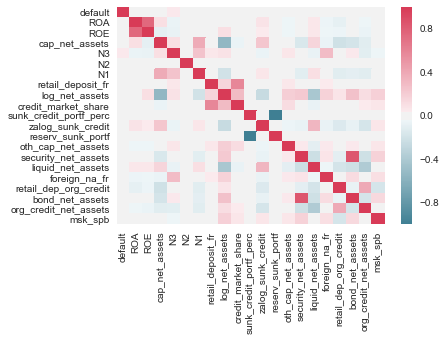

In [572]:
sns.set(style="white")


# Compute the correlation matrix
corr = df_macro[['default',            # тагрет
               'ROA', 'ROE',            # прибыльность
               'cap_net_assets',        # достаточность капитала
               'N3', 'N2', 'N1', 'retail_deposit_fr',   # ликвидность
               'log_net_assets',        # размер банка
               'credit_market_share',   # монопольная власть
               'sunk_credit_portf_perc', 'zalog_sunk_credit',   # качество кредит портфеля
               'reserv_sunk_portf', 'oth_cap_net_assets',  'security_net_assets', 'liquid_net_assets',  # фальсификация 1
               'foreign_na_fr',         # фальсификация 2
               'retail_dep_org_credit', # фальсификация 3
               'bond_net_assets', 'org_credit_net_assets',  # структура активов
               'msk_spb']].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(2, 11))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 6, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
%matplotlib inline
# sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, square=True, linewidths=.5, cbar_kws={"shrink": .5})
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            cmap=cmap)

Посмотрим на корреляцию тех факторов, у которых она > 0.4 по модулю

In [573]:
df_macro[['bond_net_assets', 'security_net_assets']].corr() # применим PCA

,bond_net_assets,security_net_assets
bond_net_assets,1.00000,0.84881
security_net_assets,0.84881,1.00000


In [574]:
df_macro[['ROA', 'ROE']].corr() # применим PCA

,ROA,ROE
ROA,1.000000,0.755374
ROE,0.755374,1.000000


In [575]:
df_macro[['HHI_credit_diff', 'usd_rub_return']].corr() # уберу HHI из-за низкой разделительной способности

,HHI_credit_diff,usd_rub_return
HHI_credit_diff,1.000000,0.715191
usd_rub_return,0.715191,1.000000


In [576]:
df_macro.drop(['HHI_credit_diff'], axis = 1, inplace =True)

PCA нужно обучать только на train, поэтому сделаем это на следующем шаге

Также удалим сильно коррелированные макро переменные (анализ выполнен в R при их формировании), ввиду их низкой разделяющей способности

In [54]:
macro = pd.read_csv('save_ok4.csv',sep=';', header = 0)
macro.drop(['Unnamed: 0'], axis = 1, inplace = True)
macro.set_index(['Date'])

,INF_SA,NX_growth,micex_std,miacr_std,miacr_amount,usd_rub_std_diff,micex_return,net_foreign_assets_diff,net_gov_debt_diff,other_fin_debt_diff,retail_debt_SA_DETREND_diff,stocks_capital_diff,i_retail_spread_diff,usd_rub_return,miacr_diff
Date,,,,,,,,,,,,,,,
01.01.2010,0.020000,0,32.00000,1.181512,2643995,1.081969,0.000000,-156425,1595305,47521,33587.305320,214757,0.000000e+00,0.008065,-0.830116
01.02.2010,0.020000,2728,29.75618,0.724981,2643995,1.081969,0.000000,-156425,1595305,47521,33587.305320,214757,0.000000e+00,0.008065,-0.830116
01.03.2010,0.027475,-980,40.07545,0.330918,2643995,-0.527030,-0.057148,225429,-265831,-34392,22186.023490,59909,-1.000000e-01,0.010699,-0.172562
01.04.2010,0.024986,-299,23.77384,0.359785,2643995,0.345271,0.043424,-128438,430871,-21876,-14983.528850,4293,1.000000e-01,-0.019848,-0.296650
01.05.2010,0.021233,-767,25.82706,0.246044,2643995,-0.334974,0.048447,-223667,92737,-1075,-19523.941080,64243,-1.000000e-01,-0.012387,-0.255000
01.06.2010,0.032372,-1736,53.69817,0.137915,2643995,2.929403,-0.105536,251702,-134963,81,-20743.437460,36008,1.000000e-01,0.042533,-0.533087
01.07.2010,0.021449,174,27.23523,0.227669,2643995,-0.498100,0.019184,386961,172577,-10752,12265.155380,-26972,3.000000e-01,0.024295,-0.194035
01.08.2010,0.017374,-2312,41.47539,0.251746,2643995,0.209606,0.000263,359324,-180240,17691,-1595.165212,41239,-2.000000e-01,-0.015886,0.067122
01.09.2010,0.026267,-2260,25.54005,0.113344,2585526,-0.072256,0.025276,61169,-21263,31859,-1961.800896,80134,-1.000000e-01,-0.010695,-0.042728


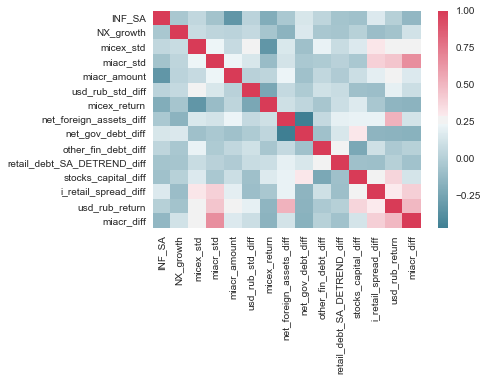

In [55]:
sns.set(style="white")


# Compute the correlation matrix
corr = macro.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(2, 11))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 6, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
%matplotlib inline
# sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, square=True, linewidths=.5, cbar_kws={"shrink": .5})
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            cmap=cmap)

In [577]:
df_macro.drop(["miacr_std", "miacr_diff", "net_foreign_assets_diff"], axis = 1, inplace = True)

In [578]:
df_macro.to_csv('dataset_ok4.csv',sep=',',header=True,index=True)

# Тест на разделяющую способность (равенство средних в двух группах)

Нужен, чтобы отбирать одну переменную из группы сильно коррелированных 
H0: mu(x) = mu(y) 
p-value > 0.05 => H0 принимается

In [579]:
from scipy.stats import ttest_ind
def mean_equal_test(variable, df):
    variable = str(variable)
    x = df[df['default'] == 0][variable]
    y = df[df['default'] == 1][variable]
    t_test = ttest_ind(x, y, equal_var = False)
    return(t_test.pvalue)

In [580]:
vars = df_macro.columns
for name in vars:
    a = mean_equal_test(name, df_macro)
    print([name, a])

['default', 0.0]
['ROA', 5.186558066842457e-05]
['ROE', 1.4383751419581332e-09]
['cap_net_assets', 0.0016493954774176518]
['N3', 9.2052326774270743e-22]
['N2', 0.015413213376814101]
['N1', 0.56196201786269739]
['retail_deposit_fr', 3.9592141060506683e-05]
['log_net_assets', 4.1731315113466842e-08]
['credit_market_share', 1.1149357432777548e-30]
['sunk_credit_portf_perc', 0.046034507601400314]
['zalog_sunk_credit', 0.89283636184840609]
['reserv_sunk_portf', 0.046013154920653727]
['oth_cap_net_assets', 3.0243895839860408e-05]
['security_net_assets', 4.5340600079092805e-16]
['liquid_net_assets', 0.014641367954096086]
['foreign_na_fr', 6.8792564334026795e-10]
['retail_dep_org_credit', 1.1386844241025851e-10]
['bond_net_assets', 2.2979587454149451e-20]
['org_credit_net_assets', 0.011886449934146079]
['msk_spb', 0.00091999011608860832]
['INF_SA', 4.4229302717924339e-25]
['NX_growth', 0.48783895424215462]
['micex_std', 0.16910556256330653]
['miacr_amount', 8.6647915146635073e-38]
['usd_rub_st

In [581]:
df_macro.to_csv('dataset_ok5.csv',sep=',',header=True,index=True)

# Финальные аккорды
## 1. train-test split 
## 2. oversampling
## 3. PCA

In [2]:
df_macro = pd.read_csv('dataset_ok5.csv',sep=',', header = 0,  encoding="cp1251")
df_macro['дата'] = pd.to_datetime(df_macro['дата'])
df_macro['лицензия'] = df_macro['лицензия'].astype(int)

In [3]:
df_train = df_macro[df_macro['дата'] < '2017-01-01']
df_test = df_macro[df_macro['дата'] >= '2017-01-01']

In [4]:
# train-test split
a = df_train[df_train['default'] == 1]['default'].count() / df_train.shape[0]
b = df_test[df_test['default'] == 1]['default'].count() / df_test.shape[0]
print('доля банкротов на train:','',np.round(a,4))
print('доля банкротов на test:','',np.round(b,4))

доля банкротов на train:  0.0153
доля банкротов на test:  0.0171


In [5]:
# oversampling
bankrot_train = df_train[df_train['default'] == 1]
bankrot_test = df_test[df_test['default'] == 1]
n = 30 # кол-во раз, во сколько увеличивается число банкротов
for i in range(n):
    df_train = df_train.append(bankrot_train)
    # df_test = df_test.append(bankrot_test)

In [6]:
a = df_train[df_train['default'] == 1]['default'].count() / df_train.shape[0]
b = df_test[df_test['default'] == 1]['default'].count() / df_test.shape[0]
print('доля банкротов на train:','',np.round(a,4))
print('доля банкротов на test:','',np.round(b,4))

доля банкротов на train:  0.3249
доля банкротов на test:  0.0171


Теперь классы сбалансированы!

In [7]:
# PCA
from sklearn.preprocessing import StandardScaler
scaler_1 = StandardScaler()
scaler_2 = StandardScaler()

df_train_pca_profit = df_train[['ROA', 'ROE']]
df_test_pca_profit = df_test[['ROA', 'ROE']]
scaler_1.fit(df_train_pca_profit)
df_train_pca_profit = scaler_1.transform(df_train_pca_profit)
df_test_pca_profit = scaler_1.transform(df_test_pca_profit)

df_train_pca_assets = df_train[['bond_net_assets', 'security_net_assets']]
df_test_pca_assets = df_test[['bond_net_assets', 'security_net_assets']]
scaler_2.fit(df_train_pca_assets)
df_train_pca_assets = scaler_2.transform(df_train_pca_profit)
df_test_pca_assets = scaler_2.transform(df_test_pca_profit)

from sklearn.decomposition import PCA
pca_1 = PCA()
pca_2 = PCA()

pca_1.fit(df_train_pca_profit)
pca_2.fit(df_train_pca_assets)

df_train_pca_profit = pd.DataFrame(pca_1.transform(df_train_pca_profit))
df_train_pca_profit.columns = ['PC_1_profit', 'PC_2_profit']
df_test_pca_profit = pd.DataFrame(pca_1.transform(df_test_pca_profit))
df_test_pca_profit.columns = ['PC_1_profit', 'PC_2_profit']


df_train_pca_assets = pd.DataFrame(pca_2.transform(df_train_pca_assets))
df_train_pca_assets.columns = ['PC_1_assets', 'PC_2_assets']
df_test_pca_assets = pd.DataFrame(pca_1.transform(df_test_pca_assets))
df_test_pca_assets.columns = ['PC_1_assets', 'PC_2_assets']

Анализ PCA для profit

In [101]:
pca_1.explained_variance_ratio_

array([ 0.8848537,  0.1151463])

In [102]:
pca_1.components_[0] # ROA & ROE

array([ 0.70710678,  0.70710678])

Анализ РСА для assets

In [103]:
pca_2.explained_variance_ratio_ 

array([ 0.89029681,  0.10970319])

In [104]:
pca_2.components_[0] # bond_net_assets & security_net_assets

array([ 0.79394392,  0.607991  ])

In [8]:
df_train['PC_1_profit'] = df_train_pca_profit['PC_1_profit'].values
df_test['PC_1_profit'] = df_test_pca_profit['PC_1_profit'].values
df_train['PC_1_assets'] = df_train_pca_assets['PC_1_assets'].values
df_test['PC_1_assets'] = df_test_pca_assets['PC_1_assets'].values

C:\Users\imaksimov002\AppData\Local\Continuum\anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\imaksimov002\AppData\Local\Continuum\anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [9]:
df_train.drop(['ROA', 'ROE', 'bond_net_assets', 'security_net_assets'], axis = 1, inplace = True)
df_test.drop(['ROA', 'ROE', 'bond_net_assets', 'security_net_assets'], axis = 1, inplace = True)

C:\Users\imaksimov002\AppData\Local\Continuum\anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [10]:
df_train.head(3)

,лицензия,дата,default,cap_net_assets,N3,N2,N1,retail_deposit_fr,log_net_assets,credit_market_share,...,usd_rub_std_diff,micex_return,net_gov_debt_diff,other_fin_debt_diff,retail_debt_SA_DETREND_diff,stocks_capital_diff,i_retail_spread_diff,usd_rub_return,PC_1_profit,PC_1_assets
0,0,2010-02-01,0.0,53.889560,92.27,9915.0,2058.0,482234.0,12.955170,0.000015,...,1.081969,0.000000,1595305,47521,33587.30532,214757,0.0,0.008065,-0.303329,-0.023689
1,0,2010-03-01,0.0,45.856131,92.27,9915.0,2058.0,482234.0,13.119182,0.000015,...,-0.527030,-0.057148,-265831,-34392,22186.02349,59909,-0.1,0.010699,-0.177550,-0.012602
2,0,2010-04-01,0.0,40.013480,92.27,9915.0,2058.0,482234.0,13.255531,0.002000,...,0.345271,0.043424,430871,-21876,-14983.52885,4293,0.1,-0.019848,-0.230167,-0.017303


In [91]:
df_train.to_csv('train_3.csv',sep=',',header=True,index=False)
df_test.to_csv('test_3.csv',sep=',',header=True,index=False)

# Обучение моделей

In [10]:
df_train.sort_values(by = ['лицензия', 'дата'], inplace = True)
df_test.sort_values(by = ['лицензия', 'дата'], inplace = True)

df_train = df_train.set_index(['лицензия', 'дата'])
df_test = df_test.set_index(['лицензия', 'дата'])

X_test = df_test.drop(['default'], axis = 1)
y_test = df_test['default'].values
X_train = df_train.drop(['default'], axis = 1)
y_train = df_train['default']

C:\Users\imaksimov002\AppData\Local\Continuum\anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Создадим объект для кросс-валидации (нельзя перемешивать данные!)

In [11]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits = 6, shuffle = False, random_state = 42)

## _1. Logit_

In [107]:
import statsmodels.api as sm
from scipy import stats

#X_train.drop(['N2', 'N1'], axis = 1, inplace =True)
#X_test.drop(['N2', 'N1'], axis = 1, inplace =True)

X2_train = X_train
X2_train['const'] = 1
est = sm.Logit(y_train, X2_train)
est2 = est.fit()
print(est2.summary())

C:\Users\imaksimov002\AppData\Local\Continuum\anaconda\lib\site-packages\statsmodels\discrete\discrete_model.py:1214: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Optimization terminated successfully.
         Current function value: 0.558799
         Iterations 31
                           Logit Regression Results                           
Dep. Variable:                default   No. Observations:                91398
Model:                          Logit   Df Residuals:                    91391
Method:                           MLE   Df Model:                            6
Date:                Mon, 23 Apr 2018   Pseudo R-squ.:                  0.1138
Time:                        02:09:24   Log-Likelihood:                -51073.
converged:                       True   LL-Null:                       -57629.
                                        LLR p-value:                     0.000
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
cap_net_assets                 -0.0185      0.002    -11.101      0.000  

In [103]:
X_train.columns

Index(['cap_net_assets', 'N3', 'log_net_assets', 'credit_market_share',
       'sunk_credit_portf_perc', 'reserv_sunk_portf', 'oth_cap_net_assets',
       'liquid_net_assets', 'foreign_na_fr', 'retail_dep_org_credit',
       'org_credit_net_assets', 'msk_spb', 'INF_SA', 'micex_std',
       'miacr_amount', 'micex_return', 'net_gov_debt_diff',
       'other_fin_debt_diff', 'retail_debt_SA_DETREND_diff',
       'i_retail_spread_diff', 'PC_1_profit', 'PC_1_assets', 'const',
       'PC_1_profit_2', 'cap_net_assets_2', 'N3_2', 'reserv_sunk_portf_2',
       'oth_cap_net_assets_2'],
      dtype='object')

Удаление незначимых регрессоров

In [11]:
X_test.drop(['retail_deposit_fr',  'usd_rub_std_diff', 'stocks_capital_diff', 'usd_rub_return', 'N2', 'N1',
             'zalog_sunk_credit', 'NX_growth'],
            axis = 1, inplace = True)
X_train.drop(['retail_deposit_fr', 'usd_rub_std_diff', 'stocks_capital_diff', 'usd_rub_return', 'N2', 'N1',
              'zalog_sunk_credit', 'NX_growth'],
            axis = 1, inplace = True)

Включение нелинейности в модель

In [19]:
X_train['PC_1_profit_2'] = X_train['PC_1_profit']**2
X_train['cap_net_assets_2'] = X_train['cap_net_assets']**2
X_train['N3_2'] = X_train['N3']**2
X_train['N3_2'] = X_train['N3']**2


X_test['PC_1_profit_2'] = X_test['PC_1_profit']**2
X_test['cap_net_assets_2'] = X_test['cap_net_assets']**2
X_test['N3_2'] = X_test['N3']**2
X_test['N3_2'] = X_test['N3']**2

_БОЛЬШЕ НЕЛИНЕЙНОСТИ !)_

In [23]:
X_train['reserv_sunk_portf_2'] = X_train['reserv_sunk_portf']**2
X_train['oth_cap_net_assets_2'] = X_train['oth_cap_net_assets']**2
X_train['liquid_net_assets_2'] = X_train['liquid_net_assets']**2
X_train['foreign_na_fr_2'] = X_train['foreign_na_fr']**2


X_test['reserv_sunk_portf_2'] = X_test['reserv_sunk_portf']**2
X_test['oth_cap_net_assets_2'] = X_test['oth_cap_net_assets']**2
X_test['liquid_net_assets_2'] = X_test['liquid_net_assets']**2
X_test['foreign_na_fr_2'] = X_test['foreign_na_fr']**2

In [99]:
X_test.drop(['foreign_na_fr_2'],
            axis = 1, inplace = True)
X_train.drop(['foreign_na_fr_2'],
            axis = 1, inplace = True)

In [101]:
X_test.drop(['liquid_net_assets_2'],
            axis = 1, inplace = True)
X_train.drop(['liquid_net_assets_2'],
            axis = 1, inplace = True)

In [90]:
X_test.drop(['reserv_sunk_portf_2'],
            axis = 1, inplace = True)
X_train.drop(['reserv_sunk_portf_2'],
            axis = 1, inplace = True)

In [93]:
X_test.drop(['oth_cap_net_assets_2'],
            axis = 1, inplace = True)
X_train.drop(['oth_cap_net_assets_2'],
            axis = 1, inplace = True)

In [95]:
X_test.drop(['retail_dep_org_credit_2'],
            axis = 1, inplace = True)
X_train.drop(['retail_dep_org_credit_2'],
            axis = 1, inplace = True)

In [91]:
X_train.columns

Index(['cap_net_assets', 'N3', 'log_net_assets', 'credit_market_share',
       'sunk_credit_portf_perc', 'reserv_sunk_portf', 'oth_cap_net_assets',
       'liquid_net_assets', 'foreign_na_fr', 'retail_dep_org_credit',
       'org_credit_net_assets', 'msk_spb', 'INF_SA', 'micex_std',
       'miacr_amount', 'micex_return', 'net_gov_debt_diff',
       'other_fin_debt_diff', 'retail_debt_SA_DETREND_diff',
       'i_retail_spread_diff', 'PC_1_profit', 'PC_1_assets', 'const',
       'PC_1_profit_2', 'cap_net_assets_2', 'N3_2', 'oth_cap_net_assets_2',
       'retail_dep_org_credit_2'],
      dtype='object')

__Посмотрим на результаты на train__

C:\Users\imaksimov002\AppData\Local\Continuum\anaconda\lib\site-packages\statsmodels\discrete\discrete_model.py:1214: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


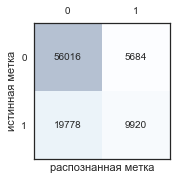

train roc-auc: 0.732
доля верно выявленных банкротов: 0.334
train accuracy: 0.721


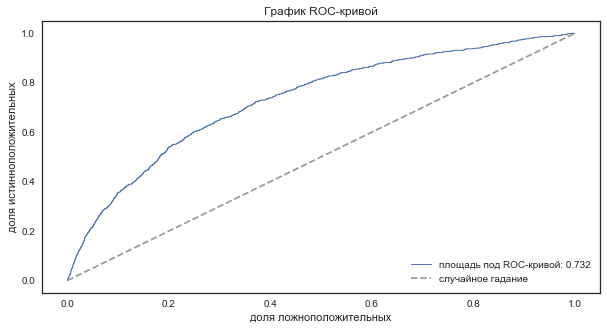

In [108]:
# confusion matrix на test
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

y_pred_p = est2.predict(X2_train)

# надо поработать с порогом...
y_pred = 1*(y_pred_p >= 0.5)

confusion_matrix = confusion_matrix(y_train, y_pred)
%matplotlib inline
fig, ax = plt.subplots(figsize = (2.5, 2.5))
ax.matshow(confusion_matrix, cmap = plt.cm.Blues, alpha = 0.3)
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        ax.text(x=j, y=i,
               s = confusion_matrix[i,j],
               va = 'center', ha = 'center')
plt.xlabel('распознанная метка')
plt.ylabel('истинная метка')
plt.figure(figsize = (25, 15))
plt.show()


rocr = roc_auc_score(y_true = y_train, y_score = y_pred_p)
share = confusion_matrix[1,1] / (confusion_matrix[1,0] + confusion_matrix[1,1])
acc = np.sum(y_train == y_pred)/len(y_train)
print('train roc-auc: %.3f' % rocr)
print('доля верно выявленных банкротов: %.3f' % share)
print('train accuracy: %.3f' % acc)

from sklearn.metrics import roc_curve, auc
from scipy import interp
%matplotlib inline

fpr, tpr, threshholds = roc_curve(y_train,
                                 y_pred_p)
roc_auc = auc(fpr, tpr)

plt.figure(figsize = (10, 5))
plt.plot(fpr, tpr, lw =1, label = 'площадь под ROC-кривой: %0.3f' % roc_auc)
plt.plot([0, 1],
         [0, 1],
         linestyle ='--',
         color = (0.6, 0.6, 0.6),
         label = 'случайное гадание')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('доля ложноположительных')
plt.ylabel('доля истинноположительных')
plt.title('График ROC-кривой')
plt.legend(loc = 'lower right')
plt.show()

__проверка на test__

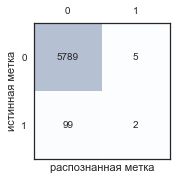

test roc-auc: 0.717
доля верно выявленных банкротов: 0.020
test accuracy: 0.982


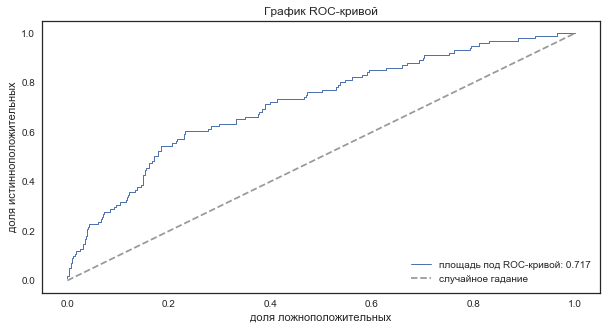

In [109]:
# confusion matrix на test
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from scipy import interp
%matplotlib inline

X2_test = X_test
X2_test['const'] = 1
y_pred_p = est2.predict(X_test)

# надо поработать с порогом...
y_pred = 1*(y_pred_p >= 0.2)

confusion_matrix = confusion_matrix(y_test, y_pred)
%matplotlib inline
fig, ax = plt.subplots(figsize = (2.5, 2.5))
ax.matshow(confusion_matrix, cmap = plt.cm.Blues, alpha = 0.3)
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        ax.text(x=j, y=i,
               s = confusion_matrix[i,j],
               va = 'center', ha = 'center')
plt.xlabel('распознанная метка')
plt.ylabel('истинная метка')
plt.figure(figsize = (25, 15))
plt.show()


rocr = roc_auc_score(y_true = y_test, y_score = y_pred_p)
share = confusion_matrix[1,1] / (confusion_matrix[1,0] + confusion_matrix[1,1])
acc = np.sum(y_test == y_pred)/len(y_test)
print('test roc-auc: %.3f' % rocr)
print('доля верно выявленных банкротов: %.3f' % share)
print('test accuracy: %.3f' % acc)


fpr, tpr, threshholds = roc_curve(y_test,
                                 y_pred_p)
roc_auc = auc(fpr, tpr)

plt.figure(figsize = (10, 5))
plt.plot(fpr, tpr, lw =1, label = 'площадь под ROC-кривой: %0.3f' % roc_auc)
plt.plot([0, 1],
         [0, 1],
         linestyle ='--',
         color = (0.6, 0.6, 0.6),
         label = 'случайное гадание')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('доля ложноположительных')
plt.ylabel('доля истинноположительных')
plt.title('График ROC-кривой')
plt.legend(loc = 'lower right')
plt.show()

# _2. Logit с регуляризацией_

0.70718657846
{'logit__C': 0.001}


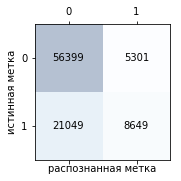

train roc-auc: 0.720
доля верно выявленных банкротов: 0.291
train accuracy: 0.712


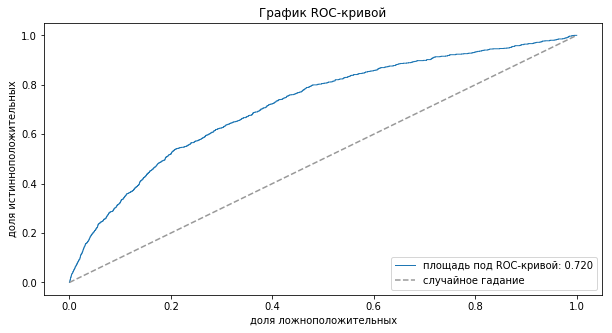

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipe_logit = Pipeline([('StSc', StandardScaler()),
                      ('logit', LogisticRegression())])
param_range = [0.00001, 0.0001 ,0.001, 0.1, 1.0]


param_grid = [{'logit__C': param_range}]

gs = GridSearchCV(estimator = pipe_logit,
                 param_grid = param_grid,
                 cv = kfold,
                 scoring = 'roc_auc',
                 n_jobs = -1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

logit_best = gs.best_estimator_
logit_best.fit(X_train, y_train)


# РЕЗУЛЬТАТЫ НА train

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from scipy import interp
%matplotlib inline

# confusion matrix
y_pred = logit_best.predict(X_train)
confusion_matrix = confusion_matrix(y_train, y_pred)

fig, ax = plt.subplots(figsize = (2.5, 2.5))
ax.matshow(confusion_matrix, cmap = plt.cm.Blues, alpha = 0.3)
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        ax.text(x=j, y=i,
               s = confusion_matrix[i,j],
               va = 'center', ha = 'center')
plt.xlabel('распознанная метка')
plt.ylabel('истинная метка')
plt.figure(figsize = (25, 15))
plt.show()

# Метрики на train
y_pred_proba = logit_best.predict_proba(X_train)
y_pred_p = np.array(pd.DataFrame(y_pred_proba).iloc[:, 1])
rocr = roc_auc_score(y_true = y_train, y_score = y_pred_p)
share = confusion_matrix[1,1] / (confusion_matrix[1,0] + confusion_matrix[1,1])
acc = np.sum(y_train == y_pred)/len(y_train)
print('train roc-auc: %.3f' % rocr)
print('доля верно выявленных банкротов: %.3f' % share)
print('train accuracy: %.3f' % acc)

## График ROC-кривой на test

fpr, tpr, threshholds = roc_curve(y_train,
                                 y_pred_p)
roc_auc = auc(fpr, tpr)

plt.figure(figsize = (10, 5))
plt.plot(fpr, tpr, lw =1, label = 'площадь под ROC-кривой: %0.3f' % roc_auc)
plt.plot([0, 1],
         [0, 1],
         linestyle ='--',
         color = (0.6, 0.6, 0.6),
         label = 'случайное гадание')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('доля ложноположительных')
plt.ylabel('доля истинноположительных')
plt.title('График ROC-кривой')
plt.legend(loc = 'lower right')
plt.show()

__Качество на кросс-валидации__

In [28]:
from sklearn.model_selection import cross_val_score
cv_roc = cross_val_score(estimator = logit_best,
                         X = X_train, y = y_train,
                         cv = kfold,
                         scoring = 'roc_auc')
cv_recall = cross_val_score(estimator = logit_best,
                         X = X_train, y = y_train,
                         cv = kfold,
                         scoring = 'recall')
cv_acc = cross_val_score(estimator = logit_best,
                         X = X_train, y = y_train,
                         cv = kfold,
                         scoring = 'accuracy')

In [29]:
print('CV roc_auc: %.3f' % cv_roc.mean(), '+/- %.3f' % cv_roc.std())
print('CV TPR: %.3f' % cv_recall.mean(), '+/- %.3f' % cv_recall.std())
print('CV accuracy: %.3f' % cv_acc.mean(), '+/- %.3f' % cv_acc.std())

CV roc_auc: 0.706 +/- 0.027
CV TPR: 0.310 +/- 0.102
CV accuracy: 0.710 +/- 0.018


__проверка на test__

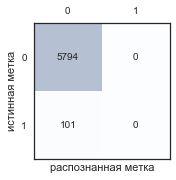

test roc-auc: 0.709
доля верно выявленных банкротов: 0.000
test accuracy: 0.983


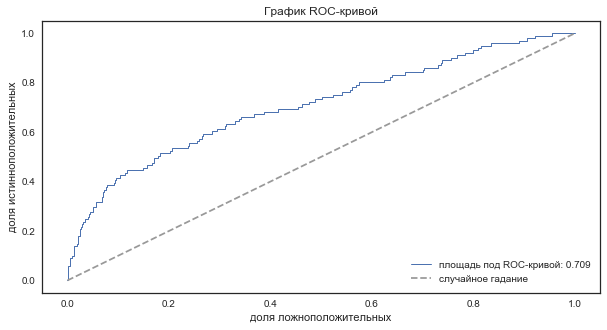

In [117]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from scipy import interp
%matplotlib inline

# confusion matrix
y_pred = logit_best.predict(X_test)
confusion_matrix = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize = (2.5, 2.5))
ax.matshow(confusion_matrix, cmap = plt.cm.Blues, alpha = 0.3)
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        ax.text(x=j, y=i,
               s = confusion_matrix[i,j],
               va = 'center', ha = 'center')
plt.xlabel('распознанная метка')
plt.ylabel('истинная метка')
plt.figure(figsize = (25, 15))
plt.show()

# Метрики на test
y_pred_proba = logit_best.predict_proba(X_test)
y_pred_p = np.array(pd.DataFrame(y_pred_proba).iloc[:, 1])
rocr = roc_auc_score(y_true = y_test, y_score = y_pred_p)
share = confusion_matrix[1,1] / (confusion_matrix[1,0] + confusion_matrix[1,1])
acc = np.sum(y_test == y_pred)/len(y_test)
print('test roc-auc: %.3f' % rocr)
print('доля верно выявленных банкротов: %.3f' % share)
print('test accuracy: %.3f' % acc)

## График ROC-кривой на test

fpr, tpr, threshholds = roc_curve(y_test,
                                 y_pred_p)
roc_auc = auc(fpr, tpr)

plt.figure(figsize = (10, 5))
plt.plot(fpr, tpr, lw =1, label = 'площадь под ROC-кривой: %0.3f' % roc_auc)
plt.plot([0, 1],
         [0, 1],
         linestyle ='--',
         color = (0.6, 0.6, 0.6),
         label = 'случайное гадание')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('доля ложноположительных')
plt.ylabel('доля истинноположительных')
plt.title('График ROC-кривой')
plt.legend(loc = 'lower right')
plt.show()

При тривиальном прогнозировании, даже зная долю банкротов на test, в среднем ложно были бы определены метки у 208,5 наблюдений. А при использовании logit с регуляризацией - 120.

# _3. Случайные лес_

{'max_depth': 6, 'n_estimators': 80}


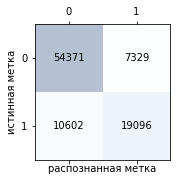

train roc-auc: 0.853
доля верно выявленных банкротов: 0.643
train accuracy: 0.804


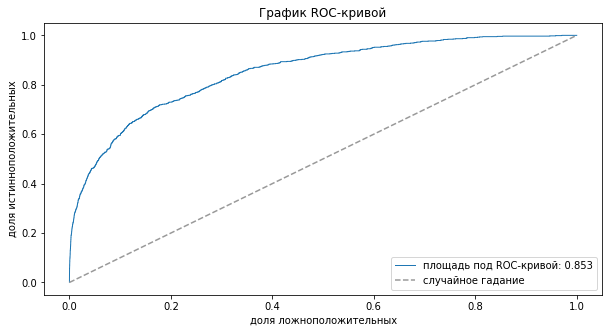

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.model_selection import GridSearchCV
from scipy import interp
%matplotlib inline

# Обучение моделей
forest = RandomForestClassifier(random_state = 42,
                               criterion = 'entropy')

param_range_1 = [80]  # количество деревьев
param_range_2 = [6]   # max глубина дерева

param_grid = [{'n_estimators': param_range_1,
              'max_depth': param_range_2}]

gs = GridSearchCV(estimator = forest,
                 param_grid = param_grid,
                 scoring = 'roc_auc', 
                 cv = kfold,
                 n_jobs = -1)

gs.fit(X_train, y_train)
print(gs.best_params_)

rf_best = gs.best_estimator_
rf_best.fit(X_train, y_train)


# РЕЗУЛЬТАТЫ

## confusion matrix на train
#y_pred = rf_best.predict(X_train)
y_pred_proba = rf_best.predict_proba(X_train)
y_pred_p = np.array(pd.DataFrame(y_pred_proba).iloc[:, 1])
y_pred = y_pred_p >= 0.4
confusion_matrix = confusion_matrix(y_train, y_pred)

fig, ax = plt.subplots(figsize = (2.5, 2.5))
ax.matshow(confusion_matrix, cmap = plt.cm.Blues, alpha = 0.3)
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        ax.text(x=j, y=i,
               s = confusion_matrix[i,j],
               va = 'center', ha = 'center')
plt.xlabel('распознанная метка')
plt.ylabel('истинная метка')
plt.figure(figsize = (25, 15))
plt.show()

# Метрики на train
y_pred_proba = rf_best.predict_proba(X_train)
y_pred_p = np.array(pd.DataFrame(y_pred_proba).iloc[:, 1])
rocr = roc_auc_score(y_true = y_train, y_score = y_pred_p)
share = confusion_matrix[1,1] / (confusion_matrix[1,0] + confusion_matrix[1,1])
acc = np.sum(y_train == y_pred)/len(y_train)
print('train roc-auc: %.3f' % rocr)
print('доля верно выявленных банкротов: %.3f' % share)
print('train accuracy: %.3f' % acc)

# График ROC-кривой на train
fpr, tpr, threshholds = roc_curve(y_train,
                                 y_pred_p)
roc_auc = auc(fpr, tpr)

plt.figure(figsize = (10, 5))
plt.plot(fpr, tpr, lw =1, label = 'площадь под ROC-кривой: %0.3f' % roc_auc)
plt.plot([0, 1],
         [0, 1],
         linestyle ='--',
         color = (0.6, 0.6, 0.6),
         label = 'случайное гадание')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('доля ложноположительных')
plt.ylabel('доля истинноположительных')
plt.title('График ROC-кривой')
plt.legend(loc = 'lower right')
plt.show()

_Кросс-валидационное качество_

In [51]:
from sklearn.model_selection import cross_val_score
cv_roc = cross_val_score(estimator = rf_best,
                         X = X_train, y = y_train,
                         cv = kfold,
                         scoring = 'roc_auc')
cv_recall = cross_val_score(estimator = rf_best,
                         X = X_train, y = y_train,
                         cv = kfold,
                         scoring = 'recall')
cv_acc = cross_val_score(estimator = rf_best,
                         X = X_train, y = y_train,
                         cv = kfold,
                         scoring = 'accuracy')

In [52]:
print('CV roc_auc: %.3f' % cv_roc.mean(), '+/- %.3f' % cv_roc.std())
print('CV TPR: %.3f' % cv_recall.mean(), '+/- %.3f' % cv_recall.std())
print('CV accuracy: %.3f' % cv_acc.mean(), '+/- %.3f' % cv_acc.std())

CV roc_auc: 0.735 +/- 0.013
CV TPR: 0.176 +/- 0.050
CV accuracy: 0.703 +/- 0.019


_Значимость фич_

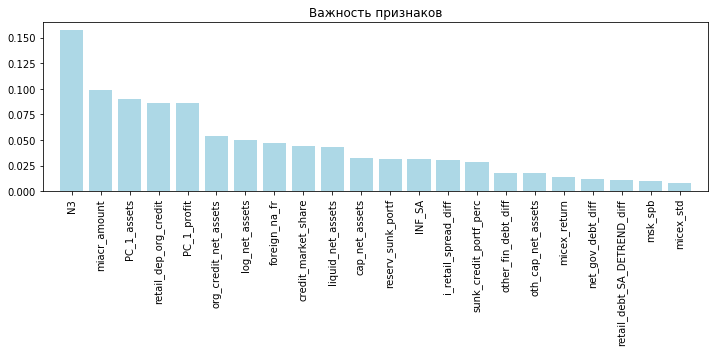

In [130]:
importances = rf_best.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize = (10, 5))
plt.title('Важность признаков')
imp_ok = np.array([])
for f in indices:
    imp_ok = np.append(imp_ok, importances[f])
plt.bar(range(X_train.shape[1]), imp_ok, color = 'lightblue', align = 'center')
feat_labels = X_train.columns
plt.xticks(range(X_train.shape[1]), feat_labels[indices], rotation = 90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

__проверка на test__

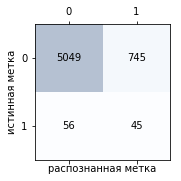

test roc-auc: 0.697
доля верно выявленных банкротов: 0.446
test accuracy: 0.864


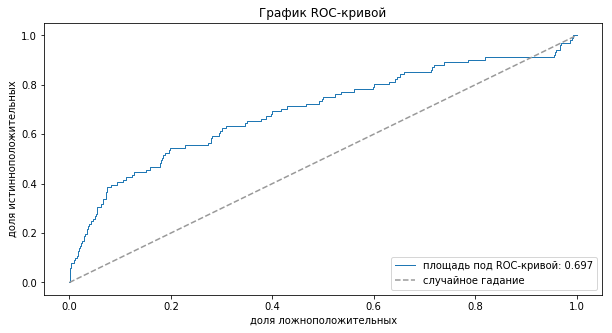

In [38]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, auc
from scipy import interp
%matplotlib inline

# confusion matrix
#y_pred = rf_best.predict(X_test)
y_pred_proba = rf_best.predict_proba(X_test)
y_pred_p = np.array(pd.DataFrame(y_pred_proba).iloc[:, 1])
y_pred = y_pred_p >= 0.5
confusion_matrix = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize = (2.5, 2.5))
ax.matshow(confusion_matrix, cmap = plt.cm.Blues, alpha = 0.3)
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        ax.text(x=j, y=i,
               s = confusion_matrix[i,j],
               va = 'center', ha = 'center')
plt.xlabel('распознанная метка')
plt.ylabel('истинная метка')
plt.figure(figsize = (25, 15))
plt.show()

# Метрики
y_pred_proba = rf_best.predict_proba(X_test)
y_pred_p = np.array(pd.DataFrame(y_pred_proba).iloc[:, 1])
rocr = roc_auc_score(y_true = y_test, y_score = y_pred_p)
share = confusion_matrix[1,1] / (confusion_matrix[1,0] + confusion_matrix[1,1])
acc = np.sum(y_test == y_pred)/len(y_test)
print('test roc-auc: %.3f' % rocr)
print('доля верно выявленных банкротов: %.3f' % share)
print('test accuracy: %.3f' % acc)

# График ROC-кривой
fpr, tpr, threshholds = roc_curve(y_test, y_pred_p)
roc_auc = auc(fpr, tpr)

plt.figure(figsize = (10, 5))
plt.plot(fpr, tpr, lw =1, label = 'площадь под ROC-кривой: %0.3f' % roc_auc)
plt.plot([0, 1],
         [0, 1],
         linestyle ='--',
         color = (0.6, 0.6, 0.6),
         label = 'случайное гадание')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('доля ложноположительных')
plt.ylabel('доля истинноположительных')
plt.title('График ROC-кривой')
plt.legend(loc = 'lower right')
plt.show()

In [39]:
y_test_a['RF'] = y_pred_p

In [41]:
for_analysis = y_test_a.copy()

In [44]:
y_test_a.drop(['index'], axis = 1, inplace = True)

In [47]:
y_test_a.set_index(X_test.index, inplace = True)

In [52]:
y_test_a.to_csv('rf_vs_catboost.csv',sep=',',header=True,index=True)

fact  CatBoost        RF
лицензия дата                                
1        2017-01-01   0.0  0.161163  0.214141
         2017-02-01   0.0  0.114065  0.233903
         2017-03-01   0.0  0.130441  0.221769
         2017-04-01   0.0  0.089042  0.198595
         2017-05-01   0.0  0.102098  0.203842
         2017-06-01   0.0  0.158763  0.221570
         2017-07-01   0.0  0.087095  0.204383
         2017-08-01   0.0  0.207640  0.214269
         2017-09-01   0.0  0.218707  0.209487
         2017-10-01   0.0  0.181080  0.201263
         2017-11-01   0.0  0.104840  0.218434
         2017-12-01   0.0  0.112159  0.182857
2        2017-01-01   0.0  0.307156  0.422392
         2017-02-01   0.0  0.438428  0.448661
         2017-03-01   0.0  0.316790  0.422406
         2017-04-01   0.0  0.171988  0.403939
         2017-05-01   0.0  0.205208  0.428501
         2017-06-01   0.0  0.440243  0.458789
         2017-07-01   0.0  0.231056  0.471049
         2017-08-01   0.0  0.208531  0.339253
         2017-09-01   0.0  0.428247  0.418959
         2017-10-01   0.0  0.247794  0.417463
         2017-11-01   0.0  0.377724  0.453437
         2017-12-01   0.0  0.274464  0.392068
21       2017-01-01   0.0  0.434722  0.403625
         2017-02-01   0.0  0.363750  0.395123
         2017-03-01   0.0  0.248730  0.409099
         2017-04-01   0.0  0.387885  0.513302
         2017-05-01   0.0  0.402386  0.505715
         2017-06-01   0.0  0.671571  0.497426
...                   ...       ...       ...
3527     2017-07-01   0.0  0.666460  0.521551
         2017-08-01   0.0  0.502043  0.443842
         2017-09-01   0.0  0.674581  0.494080
         2017-10-01   0.0  0.647844  0.477212
         2017-11-01   0.0  0.768738  0.567274
         2017-12-01   0.0  0.588991  0.499137
3528     2017-01-01   0.0  0.436580  0.470782
         2017-02-01   0.0  0.567734  0.507685
         2017-03-01   0.0  0.424423  0.514179
         2017-04-01   0.0  0.436895  0.598661
         2017-05-01   0.0  0.391038  0.564089
         2017-06-01   0.0  0.554753  0.557797
         2017-07-01   0.0  0.426808  0.547448
         2017-08-01   0.0  0.463014  0.476254
         2017-09-01   0.0  0.516111  0.554429
         2017-10-01   0.0  0.537228  0.534657
         2017-11-01   0.0  0.565867  0.513160
         2017-12-01   0.0  0.371593  0.525160
3529     2017-01-01   0.0  0.422273  0.412924
         2017-02-01   0.0  0.178867  0.417139
         2017-03-01   0.0  0.258453  0.376589
         2017-04-01   0.0  0.256715  0.389940
         2017-05-01   0.0  0.307681  0.418373
         2017-06-01   0.0  0.436417  0.470945
         2017-07-01   0.0  0.227522  0.419006
         2017-08-01   0.0  0.422484  0.402303
         2017-09-01   0.0  0.444946  0.512493
         2017-10-01   0.0  0.498526  0.507067
         2017-11-01   0.0  0.419906  0.511790
         2017-12-01   0.0  0.248556  0.473369

[5895 rows x 3 columns]

In [53]:
an = pd.read_csv('rf_vs_catboost.csv',sep=',', header = 0,  encoding="cp1251")
an['дата'] = pd.to_datetime(an['дата'])
an['лицензия'] = an['лицензия'].astype(int)

In [54]:
an.head(3)

,лицензия,дата,fact,CatBoost,RF
0,1,2017-01-01,0.0,0.161163,0.214141
1,1,2017-02-01,0.0,0.114065,0.233903
2,1,2017-03-01,0.0,0.130441,0.221769


In [115]:
an[an['лицензия'] == 96]

,лицензия,дата,fact,CatBoost,RF
109,96,2017-01-01,0.0,0.381578,0.503891
110,96,2017-02-01,0.0,0.331941,0.394904
111,96,2017-03-01,0.0,0.499775,0.442672
112,96,2017-04-01,0.0,0.302720,0.428329
113,96,2017-08-01,0.0,0.186470,0.354113
114,96,2017-09-01,0.0,0.259691,0.425749
115,96,2017-10-01,0.0,0.285878,0.423322
116,96,2017-11-01,0.0,0.264720,0.417425
117,96,2017-12-01,0.0,0.305802,0.426382


In [105]:
cb = an[an['CatBoost'] >= 0.5]
cb = cb[cb['fact'] == 1]
cb.iloc[1:20, :]


,лицензия,дата,fact,CatBoost,RF
170,153,2017-01-01,1.0,0.725465,0.511814
171,153,2017-02-01,1.0,0.525715,0.447994
196,208,2017-01-01,1.0,0.648859,0.598208
425,456,2017-01-01,1.0,0.579440,0.453243
426,467,2017-01-01,1.0,0.672560,0.531247
427,467,2017-02-01,1.0,0.750301,0.594026
428,467,2017-03-01,1.0,0.755737,0.548917
935,766,2017-01-01,1.0,0.703078,0.536961
1063,860,2017-09-01,1.0,0.734391,0.531967
1064,860,2017-10-01,1.0,0.773266,0.548654


In [ ]:
y_test_a

# _4. Ядерный метод опорных векторов_

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from scipy import interp
%matplotlib inline

# обучение моделей и выбор лучшей
svm = SVC(random_state = 42,
          kernel = 'rbf',
          probability = False,
          C = 0.1,
          gamma = 5)


param_range_1 = [5]
param_range_2 = [0.1]

param_grid = [{'gamma': param_range_1,
               'C': param_range_2}]

# gs = GridSearchCV(estimator = svm,
#                 param_grid = param_grid,
#                 scoring = 'roc_auc', 
#                 cv = kfold,
#                 n_jobs = -1)

# gs.fit(X_train, y_train)
# print('train roc-auc: %.3f' % gs.best_score_)
# print(gs.best_params_)

# svm_best = gs.best_estimator_
# svm_best.fit(X_train, y_train)

svm.fit(X_train, y_train)

#pipe_svm.fit(X_train, y_train)

# проверка на train

## confusion matrix
# y_pred = svm_best.predict(X_train)
y_pred = svm.predict(X_train)
confusion_matrix = confusion_matrix(y_train, y_pred)

%matplotlib inline
fig, ax = plt.subplots(figsize = (2.5, 2.5))
ax.matshow(confusion_matrix, cmap = plt.cm.Blues, alpha = 0.3)
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        ax.text(x=j, y=i,
               s = confusion_matrix[i,j],
               va = 'center', ha = 'center')
plt.xlabel('распознанная метка')
plt.ylabel('истинная метка')
plt.figure(figsize = (10, 5))
plt.show()

## Метрики
'''
y_pred_proba = svm_best.predict_proba(X_train)
y_pred_p = np.array(pd.DataFrame(y_pred_proba).iloc[:, 1])
rocr = roc_auc_score(y_true = y_train, y_score = y_pred_p)
'''
rocr = roc_auc_score(y_true = y_train, y_score = y_pred)

share = confusion_matrix[1,1] / (confusion_matrix[1,0] + confusion_matrix[1,1]) 
acc = np.sum(y_train == y_pred)/len(y_train)
print('test roc-auc: %.3f' % rocr)
print('доля верно выявленных банкротов: %.3f' % share)
print('test accuracy: %.3f' % acc)

## График ROC-кривой

fpr, tpr, threshholds = roc_curve(y_train, y_pred) #y_pred_p)
roc_auc = auc(fpr, tpr)
plt.figure(figsize = (10, 5))
plt.plot(fpr, tpr, lw =1, label = 'площадь под ROC-кривой: %0.3f' % roc_auc)
plt.plot([0, 1],
         [0, 1],
         linestyle ='--',
         color = (0.6, 0.6, 0.6),
         label = 'случайное гадание')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('доля ложноположительных')
plt.ylabel('доля истинноположительных')
plt.title('График ROC-кривой')
plt.legend(loc = 'lower right')

plt.show()

__проверка на test__

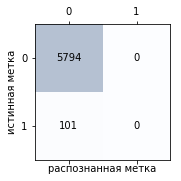

test roc-auc: 0.500
доля верно выявленных банкротов: 0.000
test accuracy: 0.983


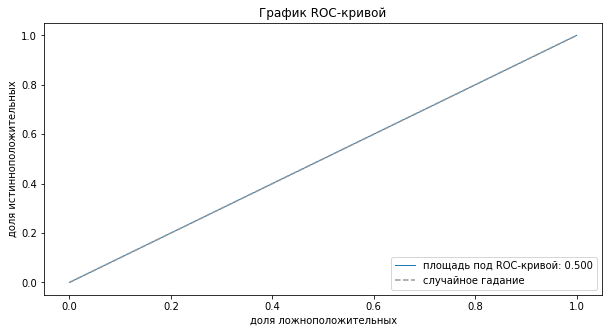

In [151]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, auc
from scipy import interp
%matplotlib inline

# confusion matrix
y_pred = svm_best.predict(X_test)
confusion_matrix = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize = (2.5, 2.5))
ax.matshow(confusion_matrix, cmap = plt.cm.Blues, alpha = 0.3)
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        ax.text(x=j, y=i,
               s = confusion_matrix[i,j],
               va = 'center', ha = 'center')
plt.xlabel('распознанная метка')
plt.ylabel('истинная метка')
plt.figure(figsize = (25, 15))
plt.show()

# Метрики
#y_pred_proba = rf_best.predict_proba(X_test)
#y_pred_p = np.array(pd.DataFrame(y_pred_proba).iloc[:, 1])
rocr = roc_auc_score(y_true = y_test, y_score = y_pred)
share = confusion_matrix[1,1] / (confusion_matrix[1,0] + confusion_matrix[1,1])
acc = np.sum(y_test == y_pred)/len(y_test)
print('test roc-auc: %.3f' % rocr)
print('доля верно выявленных банкротов: %.3f' % share)
print('test accuracy: %.3f' % acc)

# График ROC-кривой
fpr, tpr, threshholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize = (10, 5))
plt.plot(fpr, tpr, lw =1, label = 'площадь под ROC-кривой: %0.3f' % roc_auc)
plt.plot([0, 1],
         [0, 1],
         linestyle ='--',
         color = (0.6, 0.6, 0.6),
         label = 'случайное гадание')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('доля ложноположительных')
plt.ylabel('доля истинноположительных')
plt.title('График ROC-кривой')
plt.legend(loc = 'lower right')
plt.show()

# 5. CatBoost

Почему CatBoost?  
Он быстрее, и как показывает практика, работает лучше XGboost и LightGBM.  
И дань традиции российской компании)

tutorials  
https://tech.yandex.com/catboost/doc/dg/concepts/parameter-tuning-docpage/#trees-number

0:	learn: 0.6580566	total: 150ms	remaining: 14.9s
1:	learn: 0.6323010	total: 183ms	remaining: 8.98s
2:	learn: 0.6126740	total: 220ms	remaining: 7.13s
3:	learn: 0.5980055	total: 261ms	remaining: 6.25s
4:	learn: 0.5862307	total: 307ms	remaining: 5.83s
5:	learn: 0.5771740	total: 356ms	remaining: 5.58s
6:	learn: 0.5704159	total: 400ms	remaining: 5.31s
7:	learn: 0.5648194	total: 442ms	remaining: 5.08s
8:	learn: 0.5600583	total: 493ms	remaining: 4.98s
9:	learn: 0.5554444	total: 549ms	remaining: 4.94s
10:	learn: 0.5519402	total: 615ms	remaining: 4.98s
11:	learn: 0.5481650	total: 663ms	remaining: 4.86s
12:	learn: 0.5455622	total: 717ms	remaining: 4.8s
13:	learn: 0.5426307	total: 790ms	remaining: 4.85s
14:	learn: 0.5402083	total: 854ms	remaining: 4.84s
15:	learn: 0.5374206	total: 907ms	remaining: 4.76s
16:	learn: 0.5350069	total: 978ms	remaining: 4.78s
17:	learn: 0.5323640	total: 1.02s	remaining: 4.66s
18:	learn: 0.5302237	total: 1.07s	remaining: 4.57s
19:	learn: 0.5284921	total: 1.12s	remainin

63:	learn: 0.4629047	total: 3.41s	remaining: 1.92s
64:	learn: 0.4618896	total: 3.46s	remaining: 1.86s
65:	learn: 0.4608651	total: 3.5s	remaining: 1.8s
66:	learn: 0.4601170	total: 3.54s	remaining: 1.74s
67:	learn: 0.4584078	total: 3.59s	remaining: 1.69s
68:	learn: 0.4570196	total: 3.64s	remaining: 1.63s
69:	learn: 0.4562645	total: 3.68s	remaining: 1.58s
70:	learn: 0.4555496	total: 3.73s	remaining: 1.52s
71:	learn: 0.4536422	total: 3.78s	remaining: 1.47s
72:	learn: 0.4527012	total: 3.82s	remaining: 1.41s
73:	learn: 0.4518623	total: 3.88s	remaining: 1.36s
74:	learn: 0.4507122	total: 3.93s	remaining: 1.31s
75:	learn: 0.4493719	total: 3.97s	remaining: 1.25s
76:	learn: 0.4484117	total: 4.01s	remaining: 1.2s
77:	learn: 0.4479062	total: 4.05s	remaining: 1.14s
78:	learn: 0.4470524	total: 4.09s	remaining: 1.09s
79:	learn: 0.4456865	total: 4.14s	remaining: 1.03s
80:	learn: 0.4449999	total: 4.19s	remaining: 984ms
81:	learn: 0.4443461	total: 4.24s	remaining: 930ms
82:	learn: 0.4430887	total: 4.28s	

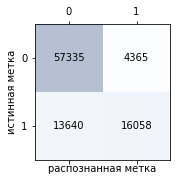

train roc-auc: 0.879
доля верно выявленных банкротов: 0.541
train accuracy: 0.803


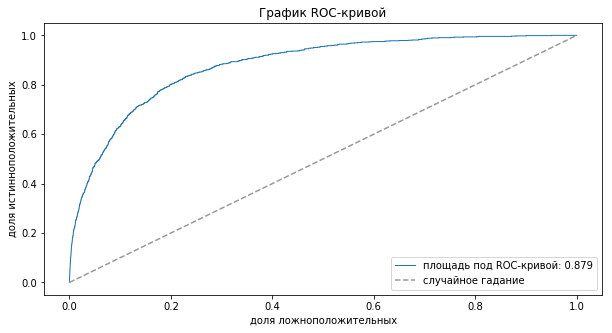

In [12]:
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV
from scipy import interp
%matplotlib inline

# Initialize CatBoostClassifier
model = CatBoostClassifier(iterations=100,
                           loss_function= 'CrossEntropy')

param_range_bagging = [0.7]
param_range_rsm = [0.7]
param_range_depth = [3, 4]
param_range_learning_rate = [0.15]
param_range_l2_leaf_reg = [15]

param_grid = [{'bagging_temperature': param_range_bagging,
               'rsm': param_range_rsm,
               'learning_rate': param_range_learning_rate,
               'depth': param_range_depth,
               'l2_leaf_reg': param_range_l2_leaf_reg}]

gs = GridSearchCV(estimator = model,
                 param_grid = param_grid,
                 scoring = 'roc_auc', 
                 cv = kfold,
                 n_jobs = -1)

gs.fit(X_train, y_train)

print(gs.best_params_)

cb_best = gs.best_estimator_
cb_best.fit(X_train, y_train)


# РЕЗУЛЬТАТЫ на train

y_pred = cb_best.predict(X_train)
confusion_matrix = confusion_matrix(y_train, y_pred)

%matplotlib inline
fig, ax = plt.subplots(figsize = (2.5, 2.5))
ax.matshow(confusion_matrix, cmap = plt.cm.Blues, alpha = 0.3)
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        ax.text(x=j, y=i,
               s = confusion_matrix[i,j],
               va = 'center', ha = 'center')
plt.xlabel('распознанная метка')
plt.ylabel('истинная метка')
plt.figure(figsize = (10, 5))
plt.show()

## Метрики

y_pred_proba = cb_best.predict_proba(X_train)
y_pred_p = np.array(pd.DataFrame(y_pred_proba).iloc[:, 1])
rocr = roc_auc_score(y_true = y_train, y_score = y_pred_p)


share = confusion_matrix[1,1] / (confusion_matrix[1,0] + confusion_matrix[1,1]) 
acc = np.sum(y_train == y_pred)/len(y_train)
print('train roc-auc: %.3f' % rocr)
print('доля верно выявленных банкротов: %.3f' % share)
print('train accuracy: %.3f' % acc)

## График ROC-кривой

fpr, tpr, threshholds = roc_curve(y_train, y_pred_p) 
roc_auc = auc(fpr, tpr)
plt.figure(figsize = (10, 5))
plt.plot(fpr, tpr, lw =1, label = 'площадь под ROC-кривой: %0.3f' % roc_auc)
plt.plot([0, 1],
         [0, 1],
         linestyle ='--',
         color = (0.6, 0.6, 0.6),
         label = 'случайное гадание')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('доля ложноположительных')
plt.ylabel('доля истинноположительных')
plt.title('График ROC-кривой')
plt.legend(loc = 'lower right')

plt.show()

_Кросс-валидационное качество_

In [46]:
from sklearn.model_selection import cross_val_score
cv_roc = cross_val_score(estimator = cb_best,
                         X = X_train, y = y_train,
                         cv = kfold,
                         scoring = 'roc_auc')
cv_recall = cross_val_score(estimator = cb_best,
                         X = X_train, y = y_train,
                         cv = kfold,
                         scoring = 'recall')
cv_acc = cross_val_score(estimator = cb_best,
                         X = X_train, y = y_train,
                         cv = kfold,
                         scoring = 'accuracy')

0:	learn: 0.6558894	total: 43.8ms	remaining: 4.34s
1:	learn: 0.6303224	total: 85.2ms	remaining: 4.18s
2:	learn: 0.6100877	total: 124ms	remaining: 4s
3:	learn: 0.5945293	total: 168ms	remaining: 4.02s
4:	learn: 0.5831119	total: 207ms	remaining: 3.93s
5:	learn: 0.5727590	total: 246ms	remaining: 3.85s
6:	learn: 0.5656222	total: 291ms	remaining: 3.87s
7:	learn: 0.5582870	total: 338ms	remaining: 3.89s
8:	learn: 0.5519046	total: 380ms	remaining: 3.85s
9:	learn: 0.5474120	total: 424ms	remaining: 3.81s
10:	learn: 0.5428946	total: 473ms	remaining: 3.83s
11:	learn: 0.5365125	total: 534ms	remaining: 3.92s
12:	learn: 0.5327624	total: 596ms	remaining: 3.99s
13:	learn: 0.5287433	total: 644ms	remaining: 3.96s
14:	learn: 0.5260314	total: 692ms	remaining: 3.92s
15:	learn: 0.5224639	total: 741ms	remaining: 3.89s
16:	learn: 0.5194795	total: 784ms	remaining: 3.83s
17:	learn: 0.5165847	total: 842ms	remaining: 3.84s
18:	learn: 0.5141292	total: 888ms	remaining: 3.78s
19:	learn: 0.5105177	total: 936ms	remainin

65:	learn: 0.4068860	total: 3.08s	remaining: 1.58s
66:	learn: 0.4047856	total: 3.12s	remaining: 1.54s
67:	learn: 0.4033470	total: 3.17s	remaining: 1.49s
68:	learn: 0.4020886	total: 3.2s	remaining: 1.44s
69:	learn: 0.4008910	total: 3.24s	remaining: 1.39s
70:	learn: 0.3997043	total: 3.3s	remaining: 1.35s
71:	learn: 0.3989005	total: 3.35s	remaining: 1.3s
72:	learn: 0.3974293	total: 3.39s	remaining: 1.25s
73:	learn: 0.3956949	total: 3.42s	remaining: 1.2s
74:	learn: 0.3947857	total: 3.46s	remaining: 1.15s
75:	learn: 0.3929818	total: 3.5s	remaining: 1.1s
76:	learn: 0.3914016	total: 3.54s	remaining: 1.06s
77:	learn: 0.3904390	total: 3.58s	remaining: 1.01s
78:	learn: 0.3894035	total: 3.62s	remaining: 961ms
79:	learn: 0.3876167	total: 3.65s	remaining: 912ms
80:	learn: 0.3853295	total: 3.68s	remaining: 864ms
81:	learn: 0.3840996	total: 3.71s	remaining: 815ms
82:	learn: 0.3832502	total: 3.75s	remaining: 768ms
83:	learn: 0.3818438	total: 3.8s	remaining: 723ms
84:	learn: 0.3808584	total: 3.83s	rema

30:	learn: 0.4734181	total: 1.33s	remaining: 2.95s
31:	learn: 0.4712463	total: 1.37s	remaining: 2.92s
32:	learn: 0.4689184	total: 1.41s	remaining: 2.87s
33:	learn: 0.4663337	total: 1.45s	remaining: 2.81s
34:	learn: 0.4640086	total: 1.48s	remaining: 2.76s
35:	learn: 0.4615666	total: 1.52s	remaining: 2.71s
36:	learn: 0.4597542	total: 1.57s	remaining: 2.67s
37:	learn: 0.4576916	total: 1.61s	remaining: 2.62s
38:	learn: 0.4563091	total: 1.65s	remaining: 2.58s
39:	learn: 0.4540813	total: 1.69s	remaining: 2.54s
40:	learn: 0.4519803	total: 1.74s	remaining: 2.5s
41:	learn: 0.4499107	total: 1.78s	remaining: 2.46s
42:	learn: 0.4481627	total: 1.83s	remaining: 2.42s
43:	learn: 0.4461884	total: 1.86s	remaining: 2.37s
44:	learn: 0.4445588	total: 1.9s	remaining: 2.33s
45:	learn: 0.4422865	total: 1.94s	remaining: 2.27s
46:	learn: 0.4409128	total: 1.98s	remaining: 2.23s
47:	learn: 0.4391619	total: 2.03s	remaining: 2.19s
48:	learn: 0.4375995	total: 2.07s	remaining: 2.15s
49:	learn: 0.4362924	total: 2.1s	

93:	learn: 0.3717593	total: 3.67s	remaining: 234ms
94:	learn: 0.3705987	total: 3.71s	remaining: 195ms
95:	learn: 0.3693809	total: 3.75s	remaining: 156ms
96:	learn: 0.3683869	total: 3.78s	remaining: 117ms
97:	learn: 0.3674424	total: 3.81s	remaining: 77.9ms
98:	learn: 0.3661308	total: 3.85s	remaining: 38.9ms
99:	learn: 0.3647632	total: 3.89s	remaining: 0us
0:	learn: 0.6540435	total: 33.3ms	remaining: 3.3s
1:	learn: 0.6262388	total: 66.5ms	remaining: 3.26s
2:	learn: 0.6064582	total: 100ms	remaining: 3.25s
3:	learn: 0.5896893	total: 137ms	remaining: 3.29s
4:	learn: 0.5769475	total: 173ms	remaining: 3.29s
5:	learn: 0.5675015	total: 207ms	remaining: 3.24s
6:	learn: 0.5602519	total: 250ms	remaining: 3.33s
7:	learn: 0.5531632	total: 290ms	remaining: 3.33s
8:	learn: 0.5477305	total: 323ms	remaining: 3.27s
9:	learn: 0.5396923	total: 357ms	remaining: 3.22s
10:	learn: 0.5352479	total: 399ms	remaining: 3.22s
11:	learn: 0.5311601	total: 432ms	remaining: 3.17s
12:	learn: 0.5271007	total: 478ms	remain

56:	learn: 0.4333024	total: 2.46s	remaining: 1.86s
57:	learn: 0.4317734	total: 2.52s	remaining: 1.82s
58:	learn: 0.4296898	total: 2.56s	remaining: 1.78s
59:	learn: 0.4279547	total: 2.6s	remaining: 1.74s
60:	learn: 0.4259429	total: 2.65s	remaining: 1.69s
61:	learn: 0.4241427	total: 2.69s	remaining: 1.65s
62:	learn: 0.4224167	total: 2.74s	remaining: 1.61s
63:	learn: 0.4206201	total: 2.77s	remaining: 1.56s
64:	learn: 0.4193077	total: 2.81s	remaining: 1.51s
65:	learn: 0.4172473	total: 2.86s	remaining: 1.47s
66:	learn: 0.4158796	total: 2.91s	remaining: 1.43s
67:	learn: 0.4146063	total: 2.95s	remaining: 1.39s
68:	learn: 0.4126635	total: 3s	remaining: 1.35s
69:	learn: 0.4109776	total: 3.04s	remaining: 1.3s
70:	learn: 0.4094761	total: 3.08s	remaining: 1.26s
71:	learn: 0.4081801	total: 3.12s	remaining: 1.21s
72:	learn: 0.4068603	total: 3.16s	remaining: 1.17s
73:	learn: 0.4059079	total: 3.2s	remaining: 1.13s
74:	learn: 0.4047892	total: 3.25s	remaining: 1.08s
75:	learn: 0.4033750	total: 3.29s	rem

18:	learn: 0.5004666	total: 692ms	remaining: 2.95s
19:	learn: 0.4973197	total: 734ms	remaining: 2.94s
20:	learn: 0.4933872	total: 773ms	remaining: 2.91s
21:	learn: 0.4904157	total: 808ms	remaining: 2.86s
22:	learn: 0.4883616	total: 841ms	remaining: 2.81s
23:	learn: 0.4862433	total: 876ms	remaining: 2.77s
24:	learn: 0.4827782	total: 915ms	remaining: 2.74s
25:	learn: 0.4806564	total: 953ms	remaining: 2.71s
26:	learn: 0.4776103	total: 991ms	remaining: 2.68s
27:	learn: 0.4753121	total: 1.02s	remaining: 2.63s
28:	learn: 0.4737431	total: 1.06s	remaining: 2.59s
29:	learn: 0.4712983	total: 1.09s	remaining: 2.55s
30:	learn: 0.4698694	total: 1.14s	remaining: 2.53s
31:	learn: 0.4669141	total: 1.18s	remaining: 2.5s
32:	learn: 0.4646899	total: 1.21s	remaining: 2.46s
33:	learn: 0.4614631	total: 1.24s	remaining: 2.42s
34:	learn: 0.4595025	total: 1.28s	remaining: 2.38s
35:	learn: 0.4570098	total: 1.32s	remaining: 2.35s
36:	learn: 0.4555819	total: 1.36s	remaining: 2.31s
37:	learn: 0.4538065	total: 1.4s

84:	learn: 0.3808492	total: 3.65s	remaining: 644ms
85:	learn: 0.3796505	total: 3.69s	remaining: 601ms
86:	learn: 0.3779856	total: 3.73s	remaining: 558ms
87:	learn: 0.3766813	total: 3.78s	remaining: 516ms
88:	learn: 0.3758109	total: 3.82s	remaining: 472ms
89:	learn: 0.3747908	total: 3.86s	remaining: 429ms
90:	learn: 0.3732460	total: 3.9s	remaining: 386ms
91:	learn: 0.3723028	total: 3.94s	remaining: 343ms
92:	learn: 0.3712180	total: 3.99s	remaining: 301ms
93:	learn: 0.3700612	total: 4.03s	remaining: 257ms
94:	learn: 0.3691064	total: 4.08s	remaining: 215ms
95:	learn: 0.3680417	total: 4.12s	remaining: 172ms
96:	learn: 0.3670597	total: 4.17s	remaining: 129ms
97:	learn: 0.3663416	total: 4.21s	remaining: 85.9ms
98:	learn: 0.3648915	total: 4.25s	remaining: 42.9ms
99:	learn: 0.3628443	total: 4.3s	remaining: 0us
0:	learn: 0.6537390	total: 36.7ms	remaining: 3.63s
1:	learn: 0.6255198	total: 84.7ms	remaining: 4.15s
2:	learn: 0.6046952	total: 128ms	remaining: 4.14s
3:	learn: 0.5879995	total: 165ms	r

47:	learn: 0.4375573	total: 1.88s	remaining: 2.03s
48:	learn: 0.4357407	total: 1.95s	remaining: 2.02s
49:	learn: 0.4345273	total: 2s	remaining: 2s
50:	learn: 0.4329347	total: 2.05s	remaining: 1.97s
51:	learn: 0.4316039	total: 2.08s	remaining: 1.92s
52:	learn: 0.4300238	total: 2.13s	remaining: 1.89s
53:	learn: 0.4283654	total: 2.17s	remaining: 1.85s
54:	learn: 0.4270275	total: 2.22s	remaining: 1.81s
55:	learn: 0.4255150	total: 2.25s	remaining: 1.77s
56:	learn: 0.4233459	total: 2.28s	remaining: 1.72s
57:	learn: 0.4220384	total: 2.32s	remaining: 1.68s
58:	learn: 0.4207872	total: 2.37s	remaining: 1.65s
59:	learn: 0.4192778	total: 2.42s	remaining: 1.61s
60:	learn: 0.4179398	total: 2.45s	remaining: 1.57s
61:	learn: 0.4159331	total: 2.48s	remaining: 1.52s
62:	learn: 0.4144271	total: 2.54s	remaining: 1.49s
63:	learn: 0.4128485	total: 2.57s	remaining: 1.45s
64:	learn: 0.4115776	total: 2.62s	remaining: 1.41s
65:	learn: 0.4102842	total: 2.66s	remaining: 1.37s
66:	learn: 0.4086180	total: 2.7s	rema

10:	learn: 0.5335596	total: 488ms	remaining: 3.95s
11:	learn: 0.5290250	total: 536ms	remaining: 3.93s
12:	learn: 0.5251265	total: 597ms	remaining: 3.99s
13:	learn: 0.5209620	total: 640ms	remaining: 3.93s
14:	learn: 0.5177726	total: 683ms	remaining: 3.87s
15:	learn: 0.5145190	total: 744ms	remaining: 3.91s
16:	learn: 0.5112606	total: 794ms	remaining: 3.88s
17:	learn: 0.5071543	total: 845ms	remaining: 3.85s
18:	learn: 0.5038412	total: 902ms	remaining: 3.85s
19:	learn: 0.5000213	total: 952ms	remaining: 3.81s
20:	learn: 0.4971979	total: 1.01s	remaining: 3.8s
21:	learn: 0.4938493	total: 1.05s	remaining: 3.73s
22:	learn: 0.4898868	total: 1.1s	remaining: 3.69s
23:	learn: 0.4876133	total: 1.15s	remaining: 3.63s
24:	learn: 0.4857378	total: 1.2s	remaining: 3.59s
25:	learn: 0.4834254	total: 1.25s	remaining: 3.57s
26:	learn: 0.4801899	total: 1.3s	remaining: 3.53s
27:	learn: 0.4763743	total: 1.35s	remaining: 3.47s
28:	learn: 0.4738018	total: 1.39s	remaining: 3.41s
29:	learn: 0.4719345	total: 1.44s	r

73:	learn: 0.3910109	total: 2.88s	remaining: 1.01s
74:	learn: 0.3894018	total: 2.93s	remaining: 977ms
75:	learn: 0.3877801	total: 2.97s	remaining: 939ms
76:	learn: 0.3862538	total: 3.02s	remaining: 903ms
77:	learn: 0.3850791	total: 3.07s	remaining: 867ms
78:	learn: 0.3831976	total: 3.13s	remaining: 831ms
79:	learn: 0.3822272	total: 3.18s	remaining: 795ms
80:	learn: 0.3804503	total: 3.23s	remaining: 757ms
81:	learn: 0.3793332	total: 3.27s	remaining: 719ms
82:	learn: 0.3782297	total: 3.31s	remaining: 678ms
83:	learn: 0.3766928	total: 3.37s	remaining: 641ms
84:	learn: 0.3757023	total: 3.41s	remaining: 602ms
85:	learn: 0.3746595	total: 3.46s	remaining: 563ms
86:	learn: 0.3733120	total: 3.49s	remaining: 522ms
87:	learn: 0.3716141	total: 3.53s	remaining: 481ms
88:	learn: 0.3703366	total: 3.57s	remaining: 441ms
89:	learn: 0.3692809	total: 3.62s	remaining: 402ms
90:	learn: 0.3680719	total: 3.66s	remaining: 362ms
91:	learn: 0.3670312	total: 3.69s	remaining: 321ms
92:	learn: 0.3655150	total: 3.7

38:	learn: 0.4591957	total: 1.61s	remaining: 2.52s
39:	learn: 0.4579740	total: 1.65s	remaining: 2.48s
40:	learn: 0.4564579	total: 1.69s	remaining: 2.43s
41:	learn: 0.4549603	total: 1.73s	remaining: 2.38s
42:	learn: 0.4527088	total: 1.76s	remaining: 2.33s
43:	learn: 0.4510609	total: 1.79s	remaining: 2.28s
44:	learn: 0.4487907	total: 1.84s	remaining: 2.24s
45:	learn: 0.4472113	total: 1.88s	remaining: 2.21s
46:	learn: 0.4450079	total: 1.92s	remaining: 2.16s
47:	learn: 0.4432845	total: 1.95s	remaining: 2.12s
48:	learn: 0.4414504	total: 1.99s	remaining: 2.07s
49:	learn: 0.4387866	total: 2.03s	remaining: 2.03s
50:	learn: 0.4363395	total: 2.07s	remaining: 1.99s
51:	learn: 0.4331196	total: 2.12s	remaining: 1.95s
52:	learn: 0.4306240	total: 2.15s	remaining: 1.91s
53:	learn: 0.4292243	total: 2.19s	remaining: 1.87s
54:	learn: 0.4281227	total: 2.23s	remaining: 1.83s
55:	learn: 0.4262987	total: 2.28s	remaining: 1.79s
56:	learn: 0.4251294	total: 2.32s	remaining: 1.75s
57:	learn: 0.4233130	total: 2.3

In [48]:
print('CV roc_auc: %.3f' % cv_roc.mean(), '+/- %.3f' % cv_roc.std())
print('CV TPR: %.3f' % cv_recall.mean(), '+/- %.3f' % cv_recall.std())
print('CV accuracy: %.3f' % cv_acc.mean(), '+/- %.3f' % cv_acc.std())

CV roc_auc: 0.750 +/- 0.023
CV TPR: 0.277 +/- 0.053
CV accuracy: 0.721 +/- 0.018


_Значимость фич_

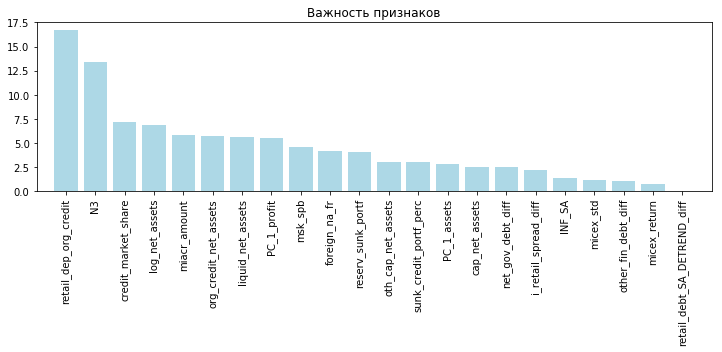

In [23]:
importances = cb_best.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize = (10, 5))
plt.title('Важность признаков')
imp_ok = np.array([])
for f in indices:
    imp_ok = np.append(imp_ok, importances[f])
plt.bar(range(X_train.shape[1]), imp_ok, color = 'lightblue', align = 'center')
feat_labels = X_train.columns
plt.xticks(range(X_train.shape[1]), feat_labels[indices], rotation = 90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

__проверка качества на test__

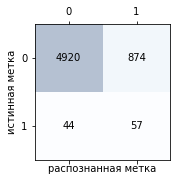

test roc-auc: 0.776
доля верно выявленных банкротов: 0.564
test accuracy: 0.844


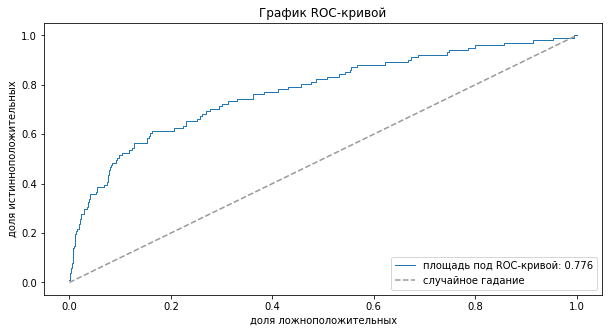

In [13]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, auc
from scipy import interp
%matplotlib inline

# confusion matrix
y_pred = cb_best.predict(X_test)
confusion_matrix = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize = (2.5, 2.5))
ax.matshow(confusion_matrix, cmap = plt.cm.Blues, alpha = 0.3)
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        ax.text(x=j, y=i,
               s = confusion_matrix[i,j],
               va = 'center', ha = 'center')
plt.xlabel('распознанная метка')
plt.ylabel('истинная метка')
plt.figure(figsize = (25, 15))
plt.show()

# Метрики
y_pred_proba = cb_best.predict_proba(X_test)
y_pred_p = np.array(pd.DataFrame(y_pred_proba).iloc[:, 1])
rocr = roc_auc_score(y_true = y_test, y_score = y_pred_p)
share = confusion_matrix[1,1] / (confusion_matrix[1,0] + confusion_matrix[1,1])
acc = np.sum(y_test == y_pred)/len(y_test)
print('test roc-auc: %.3f' % rocr)
print('доля верно выявленных банкротов: %.3f' % share)
print('test accuracy: %.3f' % acc)

# График ROC-кривой
fpr, tpr, threshholds = roc_curve(y_test, y_pred_p)
roc_auc = auc(fpr, tpr)

plt.figure(figsize = (10, 5))
plt.plot(fpr, tpr, lw =1, label = 'площадь под ROC-кривой: %0.3f' % roc_auc)
plt.plot([0, 1],
         [0, 1],
         linestyle ='--',
         color = (0.6, 0.6, 0.6),
         label = 'случайное гадание')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('доля ложноположительных')
plt.ylabel('доля истинноположительных')
plt.title('График ROC-кривой')
plt.legend(loc = 'lower right')
plt.show()

In [34]:
y_test_a = pd.DataFrame(X_test.index)
y_test_a.columns = ['index']
y_test_a['fact'] = y_test 
y_test_a['CatBoost'] = y_pred_p

In [37]:
y_test_a[y_test_a['fact'] == 1]

,index,fact,CatBoost
60,"(55, 2017-01-01 00:00:00)",1.0,0.962787
170,"(153, 2017-01-01 00:00:00)",1.0,0.725465
171,"(153, 2017-02-01 00:00:00)",1.0,0.525715
196,"(208, 2017-01-01 00:00:00)",1.0,0.648859
292,"(323, 2017-06-01 00:00:00)",1.0,0.357589
293,"(323, 2017-07-01 00:00:00)",1.0,0.184470
294,"(323, 2017-08-01 00:00:00)",1.0,0.161065
350,"(370, 2017-08-01 00:00:00)",1.0,0.258839
351,"(370, 2017-09-01 00:00:00)",1.0,0.294497
352,"(370, 2017-10-01 00:00:00)",1.0,0.438048


# 6. Bagged MARS + logit

In [ ]:
from pyearth import Earth
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingClassifier
from scipy import interp
%matplotlib inline

pipe_earth = Pipeline([('earth', Earth(max_terms = 200,
                                       max_degree = 2,
                                       penalty = 0.0001,  # ОБРАТИ НА ЭТО ВНИМАНИЕ !!!
                                       use_fast = True)),
                       ('logit', LogisticRegression(C = 10**10))])

bagged_earth = BaggingClassifier(base_estimator = pipe_earth,
                                 n_estimators = 30,
                                 max_samples = 0.7,
                                 max_features = 0.7,
                                 n_jobs = -1,
                                 random_state = 42)

# param_range = [0.1, 1.0, 10.0, 50.0, 100.0, 200.0]
# param_grid = [{'logit__C': param_range}]

# gs = GridSearchCV(estimator = pipe_logit,
#                 param_grid = param_grid,
#                 cv = kfold,
#                 scoring = 'roc_auc',
#                 n_jobs = -1)
# gs = gs.fit(X_train_nonlin, y_train)
# print(gs.best_score_)
# print(gs.best_params_)

# earth_best = gs.best_estimator_
bagged_earth.fit(X_train, y_train)

# РЕЗУЛЬТАТЫ

## confusion matrix на train
#y_pred = rf_best.predict(X_train)
y_pred_proba = bagged_earth.predict_proba(X_train)
y_pred_p = np.array(pd.DataFrame(y_pred_proba).iloc[:, 1])
y_pred = y_pred_p >= 0.4
confusion_matrix = confusion_matrix(y_train, y_pred)

fig, ax = plt.subplots(figsize = (2.5, 2.5))
ax.matshow(confusion_matrix, cmap = plt.cm.Blues, alpha = 0.3)
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        ax.text(x=j, y=i,
               s = confusion_matrix[i,j],
               va = 'center', ha = 'center')
plt.xlabel('распознанная метка')
plt.ylabel('истинная метка')
plt.figure(figsize = (25, 15))
plt.show()

# Метрики на train
y_pred_proba = bagged_earth.predict_proba(X_train)
y_pred_p = np.array(pd.DataFrame(y_pred_proba).iloc[:, 1])
rocr = roc_auc_score(y_true = y_train, y_score = y_pred_p)
share = confusion_matrix[1,1] / (confusion_matrix[1,0] + confusion_matrix[1,1])
acc = np.sum(y_train == y_pred)/len(y_train)
print('train roc-auc: %.3f' % rocr)
print('доля верно выявленных банкротов: %.3f' % share)
print('train accuracy: %.3f' % acc)

# График ROC-кривой на train
fpr, tpr, threshholds = roc_curve(y_train,
                                 y_pred_p)
roc_auc = auc(fpr, tpr)

plt.figure(figsize = (10, 5))
plt.plot(fpr, tpr, lw =1, label = 'площадь под ROC-кривой: %0.3f' % roc_auc)
plt.plot([0, 1],
         [0, 1],
         linestyle ='--',
         color = (0.6, 0.6, 0.6),
         label = 'случайное гадание')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('доля ложноположительных')
plt.ylabel('доля истинноположительных')
plt.title('График ROC-кривой')
plt.legend(loc = 'lower right')
plt.show()

In [ ]:
from sklearn.model_selection import cross_val_score
cv_roc = cross_val_score(estimator = bagged_earth,
                         X = X_train, y = y_train,
                         cv = kfold,
                         scoring = 'roc_auc')
cv_recall = cross_val_score(estimator = bagged_earth,
                         X = X_train, y = y_train,
                         cv = kfold,
                         scoring = 'recall')
cv_acc = cross_val_score(estimator = bagged_earth,
                         X = X_train, y = y_train,
                         cv = kfold,
                         scoring = 'accuracy')

In [ ]:
print('CV roc_auc: %.3f' % cv_roc.mean(), '+/- %.3f' % cv_roc.std())
print('CV TPR: %.3f' % cv_recall.mean(), '+/- %.3f' % cv_recall.std())
print('CV accuracy: %.3f' % cv_acc.mean(), '+/- %.3f' % cv_acc.std())

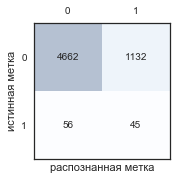

test roc-auc: 0.672
доля верно выявленных банкротов: 0.446
test accuracy: 0.798


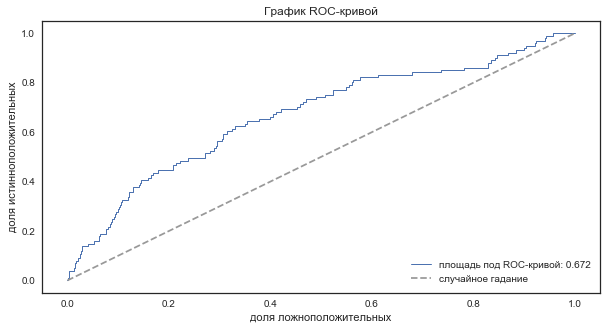

In [122]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, auc
from scipy import interp
%matplotlib inline

# confusion matrix
y_pred = bagged_earth.predict(X_test)
confusion_matrix = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize = (2.5, 2.5))
ax.matshow(confusion_matrix, cmap = plt.cm.Blues, alpha = 0.3)
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        ax.text(x=j, y=i,
               s = confusion_matrix[i,j],
               va = 'center', ha = 'center')
plt.xlabel('распознанная метка')
plt.ylabel('истинная метка')
plt.figure(figsize = (25, 15))
plt.show()

# Метрики
y_pred_proba = bagged_earth.predict_proba(X_test)
y_pred_p = np.array(pd.DataFrame(y_pred_proba).iloc[:, 1])
rocr = roc_auc_score(y_true = y_test, y_score = y_pred_p)
share = confusion_matrix[1,1] / (confusion_matrix[1,0] + confusion_matrix[1,1])
acc = np.sum(y_test == y_pred)/len(y_test)
print('test roc-auc: %.3f' % rocr)
print('доля верно выявленных банкротов: %.3f' % share)
print('test accuracy: %.3f' % acc)

# График ROC-кривой
fpr, tpr, threshholds = roc_curve(y_test, y_pred_p)
roc_auc = auc(fpr, tpr)

plt.figure(figsize = (10, 5))
plt.plot(fpr, tpr, lw =1, label = 'площадь под ROC-кривой: %0.3f' % roc_auc)
plt.plot([0, 1],
         [0, 1],
         linestyle ='--',
         color = (0.6, 0.6, 0.6),
         label = 'случайное гадание')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('доля ложноположительных')
plt.ylabel('доля истинноположительных')
plt.title('График ROC-кривой')
plt.legend(loc = 'lower right')
plt.show()